# NPIs and Behavior

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import time as time
import lmfit as lm
from scipy.signal import find_peaks
from tqdm import tqdm

blues = ['#172d42','#427fba','#b9d0e6']
purples = ['#370051','#a600f4','#de99ff']
reds = ['#ab0800','#fc0c00','#ffada9']
oranges = ['#ca4d0b','#f37d2a','#f8bb8f']
yellows = ['#e4c600','#f5ff1e','#f9ff89']
greens = ['#1e5631','#22b600','#acdf87']

# Define the Model

Global Parameters, Fixed
- $\xi$: Loss of immunity rate
- $\sigma_e$ ($\sigma_s$): Graduation rate from exposed (symptomatic) class
- $\gamma_a$ ($\gamma_h$): Recovery rate of the asymptomatic (hospitalized) class
- $r_1$: Portion of cases that are symptomatic
- $\delta_h$: death rate of the hospitalized class

In [2]:
"""
Global Fixed Paramter Values
"""
Xi = 1/180.
# Xi = 0.
Sigma_e = 1/4.
Sigma_i = 1/14.
Gamma_a = 1/9.
Gamma_h = 1/10.
r_1 = 0.6
Delta_h = 0.41
# Delta_h = 0
Beta_a = 0.625
Beta_i = 0.375
Beta_h = 0
r_2 = 0.05

p1_lockdown_start = 14 # first lockdown
p2_lockdown_start = 35 # first hard lockdown
p3_lockdown_start = 88 # slight reopening post wave 1
p4_lockdown_start = 178 # second stage reopening

Global Parameters, Fitted
- $a_1$ ($a_2$): disease-motivated behavioral modifier for group 2 (1)
- $c_{12}$  ($c_{21}$): influence-motivated behavioral modifier for group 1 (2)
- $\beta_a$ ($\beta_i$): maximum effective contact rate for asymptomatic (symptomatic) class
- $r_2$: Portion of symptomatic cases that get hospitalized
- $\theta_l$: impact of gov't restrictions on disease transmission

In [3]:
def full_model(states, t, a_1, a_2, c12, c21, theta_l1, theta_l2, theta_l3, theta_l4):
    S1, S2, E1, E2, A1, A2, I1, I2, H1, H2, R1, R2, D = states
    N = np.sum(states)-D
    N1 = np.sum([S1, E1, A1, I1, H1, R1])
    N2 = np.sum([S2, E2, A2, I2, H2, R2])

    cA1 = np.exp(-a_1*(H1+H2)/N)
    cA2 = np.exp(-a_2*(H1+H2)/N)

    if t >= p4_lockdown_start:
        mult = theta_l4
    elif t >= p3_lockdown_start:
        mult = theta_l3
    elif t >= p2_lockdown_start:
        mult = theta_l2
    elif t>= p1_lockdown_start:
        mult = theta_l1
    else:
        mult = 1
    
    dS1 = -mult*(cA1*S1/N) * (cA1*(Beta_a*A1 + Beta_i*I1) + cA2*(Beta_a*A2 + Beta_i*I2)) + Xi*R1 - (c21*N2*S1/N) + (c12*N1*S2/N)
    dS2 = -mult*(cA2*S2/N) * (cA1*(Beta_a*A1 + Beta_i*I1) + cA2*(Beta_a*A2 + Beta_i*I2)) + Xi*R2 + (c21*N2*S1/N) - (c12*N1*S2/N)

    dE1 = mult*(cA1*S1/N) * (cA1*(Beta_a*A1 + Beta_i*I1) + cA2*(Beta_a*A2 + Beta_i*I2)) - Sigma_e*E1 - (c21*N2*E1/N) + (c12*N1*E2/N)
    dE2 = mult*(cA2*S2/N) * (cA1*(Beta_a*A1 + Beta_i*I1) + cA2*(Beta_a*A2 + Beta_i*I2)) - Sigma_e*E2 + (c21*N2*E1/N) - (c12*N1*E2/N)

    dA1 = (1-r_1)*Sigma_e*E1 - Gamma_a*A1 - (c21*N2*A1/N) + (c12*N1*A2/N)
    dA2 = (1-r_1)*Sigma_e*E2 - Gamma_a*A2 + (c21*N2*A1/N) - (c12*N1*A2/N)

    dI1 = r_1*Sigma_e*E1 - Sigma_i*I1 - (c21*N2*I1/N) + (c12*N1*I2/N)
    dI2 = r_1*Sigma_e*E2 - Sigma_i*I2 + (c21*N2*I1/N) - (c12*N1*I2/N)

    dH1 = r_2*Sigma_i*I1 - Gamma_h*H1 - Delta_h*H1 - (c21*N2*H1/N) + (c12*N1*H2/N)
    dH2 = r_2*Sigma_i*I2 - Gamma_h*H2 - Delta_h*H2 + (c21*N2*H1/N) - (c12*N1*H2/N)

    dR1 = (1-r_2)*Sigma_i*I1 + Gamma_a*A1 + Gamma_h*H1 - Xi*R1
    dR2 = (1-r_2)*Sigma_i*I2 + Gamma_a*A2 + Gamma_h*H2 - Xi*R2

    dD = Delta_h*(H1+H2)

    return np.array([dS1, dS2, dE1, dE2, dA1, dA2, dI1, dI2, dH1, dH2, dR1, dR2, dD])

# Import Data

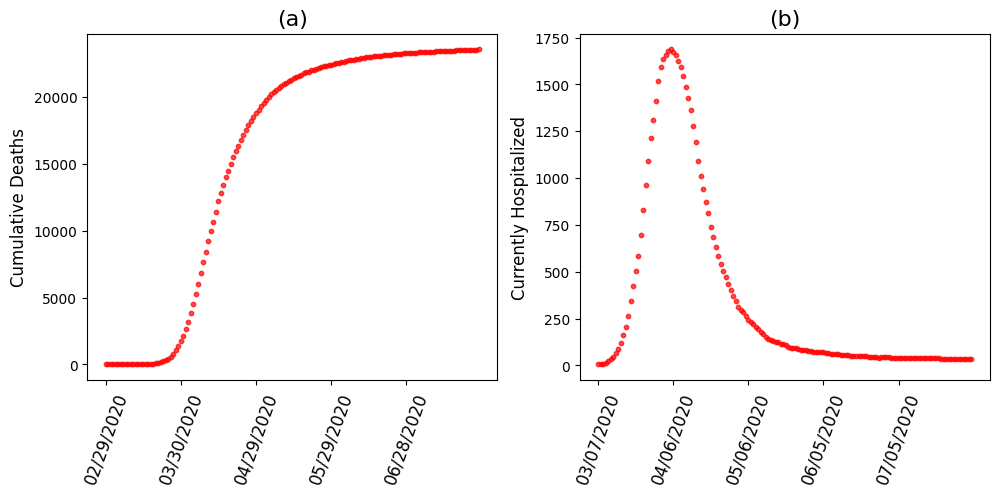

In [4]:
plt.rcParams["figure.figsize"] = (8*1.5*1.5,3*1.5)
window_length = 150

death_data = pd.read_csv('nyc_deaths_new.csv')
hosp_data = pd.read_csv('hosp_by_day.csv')[['date_of_interest','HOSPITALIZED_COUNT']]
dates = np.array(death_data['date_of_interest'])[:window_length]
dates_long = np.array(death_data['date_of_interest'])
days_long = np.arange(len(dates_long))
days = np.arange(len(dates))
dates_avgs = np.array(death_data['date_of_interest'])[7:window_length+7]
days_avgs = np.arange(7,len(dates_avgs)+7)
daily_deaths = np.array(death_data['DEATH_COUNT'])[:window_length]
daily_deaths_avgs = [np.mean(daily_deaths[i-7:i]) for i in range(7,len(daily_deaths))]
cumulative_deaths = [sum(daily_deaths[:i]) for i in range(len(days))]
# print("first wave deaths:",cumulative_deaths[150])
daily_deaths_long = np.array(death_data['DEATH_COUNT'])
daily_deaths_long_avgs = [np.mean(daily_deaths_long[i-7:i]) for i in range(7,len(daily_deaths_long))]
cumulative_deaths_long = [sum(daily_deaths_long[:i]) for i in range(len(daily_deaths_long))]
current_hospitalizations = np.array(hosp_data['HOSPITALIZED_COUNT'])[:window_length+7]
current_hospitalizations_avgs = [np.mean(current_hospitalizations[i-7:i]) for i in range(7,len(current_hospitalizations))]
# print("first wave hospitalizations:",sum(current_hospitalizations[:150]))
plt.subplot(132)
plt.scatter(days,cumulative_deaths,label='Real Data', color='red',alpha=0.7,s=10)
plt.xticks(days[::30], dates[::30],rotation=70,fontsize=12)
plt.title('(a)',fontsize=16)
plt.ylabel("Cumulative Deaths",fontsize=12)

plt.subplot(133)
plt.scatter(days_avgs,current_hospitalizations_avgs, color='red',alpha=0.7,s=10)
plt.xticks(days_avgs[::30], dates_avgs[::30],rotation=70,fontsize=12)
plt.title("(b)",fontsize=16)
plt.ylabel("Currently Hospitalized",fontsize=12)
plt.show()

# Perform Data Fitting

In [5]:
params = lm.Parameters()

# params.add('a_1', value = 9000, vary=False)
# params.add('a_factor', value=0.32, min = 0.001, max=0.75, vary=False)
# params.add('a_2', expr='a_1 * a_factor')
# params.add('c12', value=1/30, min=0.001, max=1, vary=False)
# params.add('c21', value=1/90, min=0.000, max=0.1, vary=False)
# params.add('theta_l1', value=0.7,vary=False)
# params.add('theta_l2', value=0.0015, vary=False)
# params.add('theta_l3', value=0.2, vary=False)
# params.add('theta_l4', value=0.89*0.32, vary=False)

params.add('a_1', value = 8000, min = 5000, max=10800, vary=False)
params.add('a_factor', value=0.35, min = 0.1, max=0.75, vary=False)
params.add('a_2', expr='a_1 * a_factor')                              #ci found
params.add('c12', value=0.033333, min=0.01, max=.33, vary=False)      #ci found
params.add('c21', value=0.0111111, min=1e-6, max=0.3, vary=False)     #ci found 
params.add('theta_l1', value= 0.74664, max=0.9, min=.45, vary=False)  #ci found
params.add('theta_l2', value=0.00133, max=.5, min=0.001, vary=False)
params.add('theta_l3', value=0.15427, max=.15428, min=.15426, vary=True)      #ci found
params.add('theta_l4', value=0.3097, max=0.30971, min=0.30969, vary=True)  #ci found

In [6]:
N0 = 8773000
initial_infection_size = np.array([5400,5400,400,400,0,1223,0,0,0,0,0])

def Model(days, N0, initial_infection_size, a_1, a_2, c12, c21, theta_l1, theta_l2, theta_l3, theta_l4):
    y0 = np.zeros(13)
    y0[0],y0[1] = 0, N0 - sum(initial_infection_size)
    y0[2:12] = initial_infection_size[:-1]
    y0[-1] = initial_infection_size[-1]
    t = days
    t = np.arange(0,window_length,window_length+1)
    ret = odeint(full_model, y0, t, args=(a_1, a_2, c12, c21, theta_l1, theta_l2, theta_l3, theta_l4))
    S1,S2,E1,E2,A1,A2,I1,I2,H1,H2,R1,R2,D = ret.T
    
    return t,S1,S2,E1,E2,A1,A2,I1,I1,H1,H2,R1,R2,D

def fitter(x, a_1, a_2, c12, c21, theta_l1, theta_l2, theta_l3, theta_l4):
    t,S1,S2,E1,E2,A1,A2,I1,I2,H1,H2,R1,R2,D = Model(days, N0, initial_infection_size, a_1, a_2, c12, c21, theta_l1, theta_l2, theta_l3, theta_l4)
    return H1+H2

start = time.time()
mod = lm.Model(fitter)
result = mod.fit(current_hospitalizations[0:window_length], params, method="BFGS", x=days[0:window_length])
# for p in ['a_factor','theta_l3','theta_l4']:
#     result.params[p].stderr = abs(result.params[p].value * .999)

# for p in ['c12','c21','theta_l1','theta_l2']:
#     result.params[p].stderr = abs(result.params[p].value * 1)

# for p in ['a_1']:
#     result.params[p].stderr = abs(result.params[p].value * 70)

# ci = result.conf_interval(sigmas=[1.96])
# lm.printfuncs.report_ci(ci)
end = time.time()
print(f"This took {end-start} seconds")

This took 0.0076830387115478516 seconds


Phase 0 R0=5.4
Phase 1 R0=4.031856
Phase 2 R0=0.007182000000000001
Phase 3 R0=0.833058
Phase 4 R0=1.67238
a1 = 8000, a2=2800.0
c12 = 0.033333, c21=0.0111111
θl = 0.74664


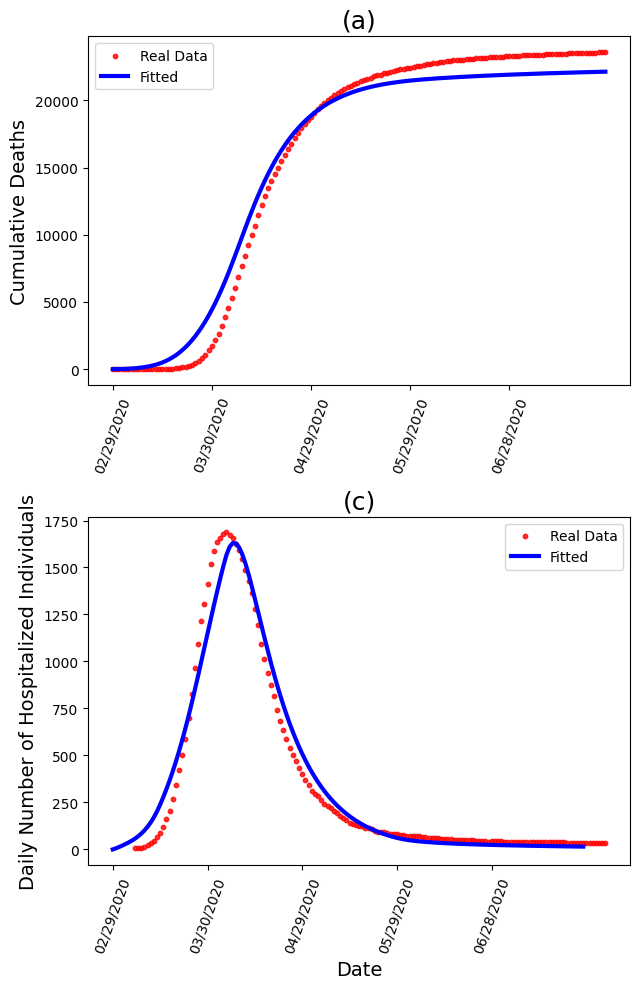

In [7]:
plt.rcParams["figure.figsize"] = (6.5,10)

a_1_fit = result.params['a_1'].value
a_2_fit = result.params['a_2'].value
a_factor_fit=result.params['a_factor'].value
c12_fit = result.params['c12'].value
c21_fit = result.params['c21'].value
theta_l1_fit = result.params['theta_l1'].value
theta_l2_fit = result.params['theta_l2'].value
theta_l3_fit = result.params['theta_l3'].value
theta_l4_fit = result.params['theta_l4'].value

basic_rep_num = lambda theta: theta*(((1-r_1)*Beta_a/Gamma_a)+(r_1*Beta_i/Sigma_i))
print(f"Phase 0 R0={basic_rep_num(1)}")
print(f"Phase 1 R0={basic_rep_num(theta_l1_fit)}")
print(f"Phase 2 R0={basic_rep_num(theta_l2_fit)}")
print(f"Phase 3 R0={basic_rep_num(theta_l3_fit)}")
print(f"Phase 4 R0={basic_rep_num(theta_l4_fit)}")


print(f"a1 = {a_1_fit},", f"a2={a_2_fit}")
print(f"c12 = {c12_fit},", f"c21={c21_fit}")
print(f"θl = {theta_l1_fit}")

plt.subplot(212)
plt.title('(c)',fontsize=18)
plt.scatter(days_avgs[:window_length],current_hospitalizations_avgs[:window_length],label='Real Data',s=10,alpha=0.8,c='r')
# plt.scatter(days[:window_length],current_hospitalizations[:window_length],label='Real Data',s=10,alpha=0.8,c='g')
y0 = np.zeros(13)
t = days
y0[0],y0[1] = 0, N0 - sum(initial_infection_size)
y0[2:12] = initial_infection_size[:-1]
y0[-1] = initial_infection_size[-1]
sol = odeint(full_model, y0, t, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
S1_sol, S2_sol, E1_sol, E2_sol, A1_sol, A2_sol, I1_sol, I2_sol, H1_sol, H2_sol, R1_sol, R2_sol, D_sol = sol[:,0],sol[:,1],sol[:,2],sol[:,3],sol[:,4],sol[:,5],sol[:,6],sol[:,7],sol[:,8],sol[:,9],sol[:,10],sol[:,11],sol[:,12]
sols = [S1_sol, S2_sol, E1_sol, E2_sol, A1_sol, A2_sol, I1_sol, I2_sol, H1_sol, H2_sol, R1_sol, R2_sol, D_sol]
plt.plot(days[:window_length],H1_sol+H2_sol,label='Fitted',color='Blue',linewidth=3.0)
plt.xticks(days[:window_length:30], dates[:window_length:30],rotation=70)
plt.xlabel("Date",fontsize=14)
plt.ylabel("Daily Number of Hospitalized Individuals",fontsize=14)
plt.legend()


plt.subplot(211)
plt.title('(a)',fontsize=18)
plt.scatter(days[:window_length],cumulative_deaths[:window_length],label='Real Data',s=10,alpha=0.8,c='r')
plt.plot(days[:window_length],D_sol,label='Fitted',color='Blue',linewidth=3.0)
plt.xticks(days[:window_length:30], dates[:window_length:30],rotation=70)

plt.ylabel("Cumulative Deaths",fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

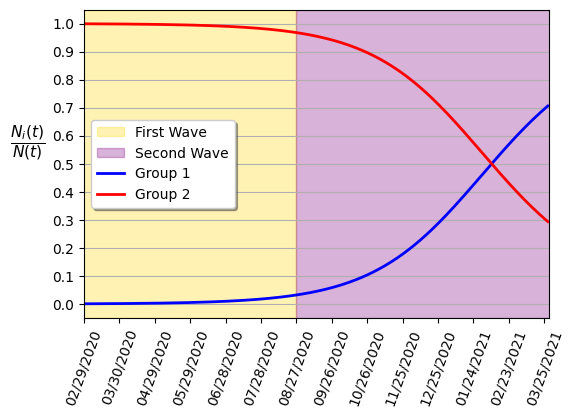

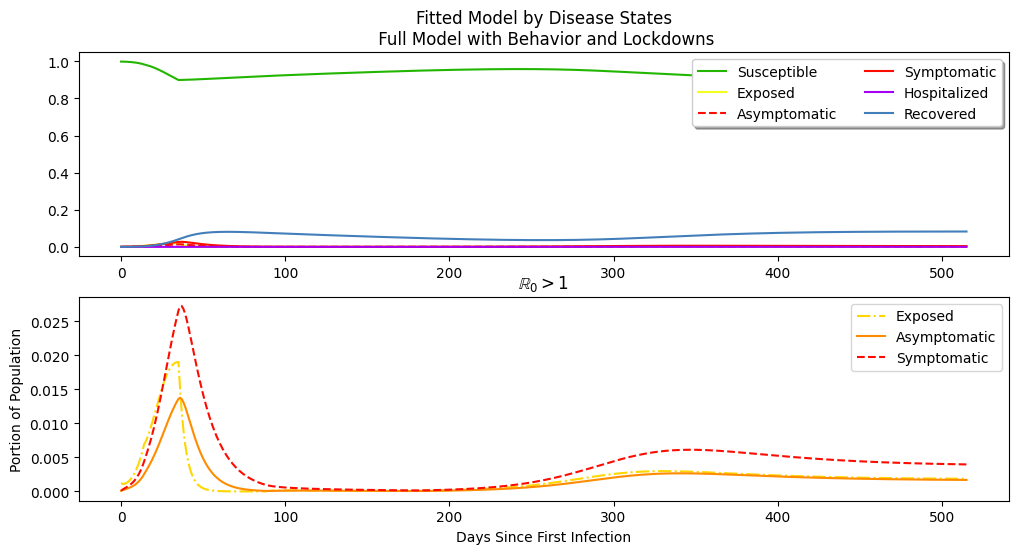

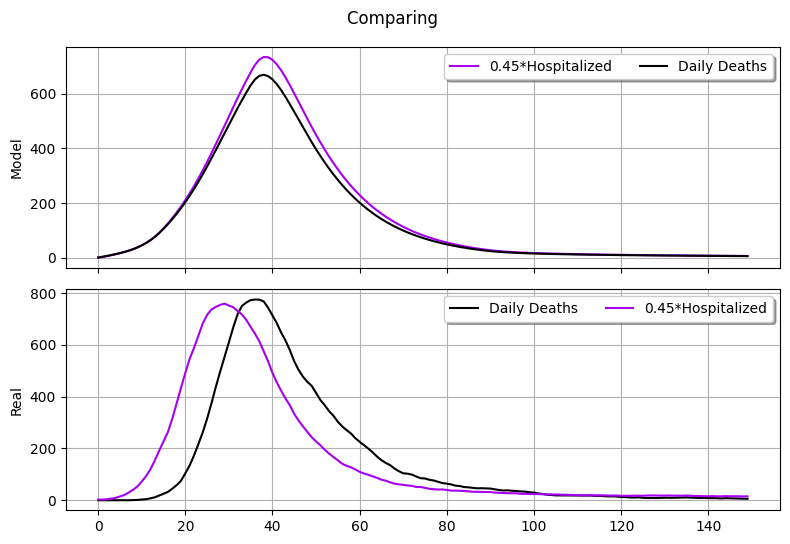

In [8]:
y0 = np.zeros(13)
y0[0],y0[1] = 0, N0 - sum(initial_infection_size)
y0[2:12] = initial_infection_size[:-1]
y0[-1] = initial_infection_size[-1]
extrayears = 1
t_long = np.linspace(0, len(days)+extrayears*365 , len(days)+extrayears*365 + 1, dtype=int)
sol_long = odeint(full_model, y0, t_long, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long = sol_long[:,0],sol_long[:,1],sol_long[:,2],sol_long[:,3],sol_long[:,4],sol_long[:,5],sol_long[:,6],sol_long[:,7],sol_long[:,8],sol_long[:,9],sol_long[:,10],sol_long[:,11],sol_long[:,12]
long_sols = [S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long]
N1_long = np.sum(long_sols[:-1:2],axis=0)
N2_long = np.sum(long_sols[1::2],axis=0)
N_long = N1_long + N2_long

plt.rcParams["figure.figsize"] = (6,4)
plt.axvspan(-10, 180, color='gold', alpha=0.3,label="First Wave") 
plt.axvspan(180, 400, color='purple', alpha=0.3,label="Second Wave") 
plt.plot(t_long[:394],(N1_long/N_long)[:394],label=r"Group 1",color='blue',linewidth=2)
plt.plot(t_long[:394],(N2_long/N_long)[:394],label=r"Group 2",color='red',linewidth=2)
plt.ylabel(r"$\frac{N_i(t)}{N(t)}$      ", fontsize=16, rotation=0)
plt.legend(fancybox=True, shadow=True, loc='center left', bbox_to_anchor=(0, 0.5))
plt.xticks(t_long[:394:30], dates_long[:394:30],rotation=70)
num_grid_lines = 11
y_ticks = np.linspace(0, 1, num_grid_lines)
plt.yticks(y_ticks)
plt.grid(axis='y')
plt.xlim(0,394)
plt.show()


S_long = S1_long+S2_long
E_long = E1_long+E2_long
A_long = A1_long+A2_long
I_long = I1_long+I2_long
H_long = H1_long+H2_long
R_long = R1_long+R2_long
plt.rcParams["figure.figsize"] = (12,9)
plt.subplot(311)
plt.plot(t_long,S_long/N0,label='Susceptible',c=greens[1])
plt.plot(t_long,E_long/N0,label='Exposed',c=yellows[1])
plt.plot(t_long,A_long/N0,'--',label='Asymptomatic',c=reds[1])
plt.plot(t_long,I_long/N0,label='Symptomatic',c=reds[1])
plt.plot(t_long,H_long/N0,label='Hospitalized',c=purples[1])
plt.plot(t_long,R_long/N0,label='Recovered',c=blues[1])
plt.legend(loc='upper right',ncol=2, fancybox=True, shadow=True)
plt.title(f"Fitted Model by Disease States\n Full Model with Behavior and Lockdowns")
# plt.xticks(t_long[::60], dates[:len(t_long):60],rotation=40)

plt.subplot(312)
plt.rcParams["figure.figsize"] = (4,3)
plt.plot(t_long,E_long/N0,'-.',label='Exposed',c='gold')
plt.plot(t_long,A_long/N0,label='Asymptomatic',c='darkorange')
plt.plot(t_long,I_long/N0,'--',label='Symptomatic',c=reds[1])
plt.title(r"$\mathbb{R}_0>1$")
plt.xlabel(r"Days Since First Infection")
plt.ylabel(r"Portion of Population")
plt.legend()
plt.show()

plt.rcParams["figure.figsize"] = (8,5.5)
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
plt.suptitle("Comparing ")
ax1.grid()
ax2.grid()
plt.subplots_adjust(hspace=-.1)
ax1.plot(t_long[:window_length],0.45*H_long[:window_length],label='0.45*Hospitalized',c=purples[1])
ax1.plot(t_long[:window_length],(D_long[1:]-D_long[:-1])[:window_length],label='Daily Deaths',c='k')
ax1.set_ylabel('Model')
ax1.legend(ncol=2, fancybox=True, shadow=True)

ax2.plot(t_long[:window_length],daily_deaths_long_avgs[:window_length],label='Daily Deaths',c='black')
ax2.plot(t_long[:window_length],0.45*np.array(current_hospitalizations_avgs[:window_length]), label='0.45*Hospitalized',c=purples[1])
ax2.set_ylabel('Real')
ax2.legend(ncol=2, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

23.14235939053348
22
32.714285714285715
9.571926323752237


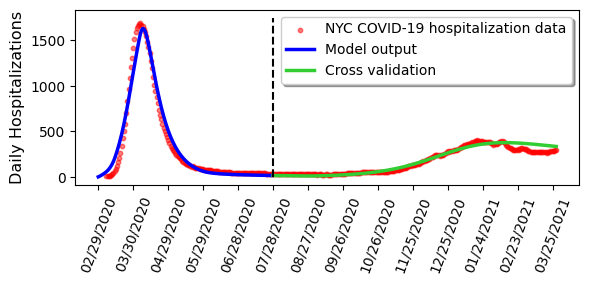

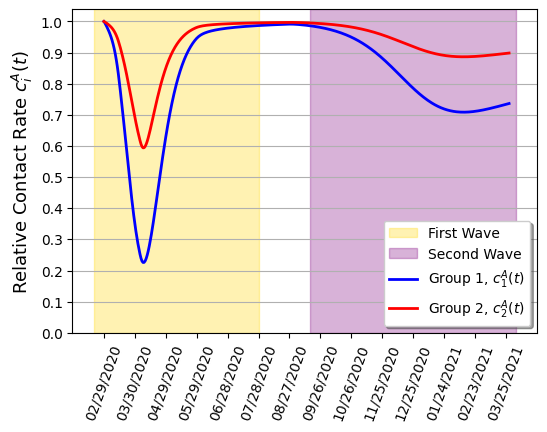

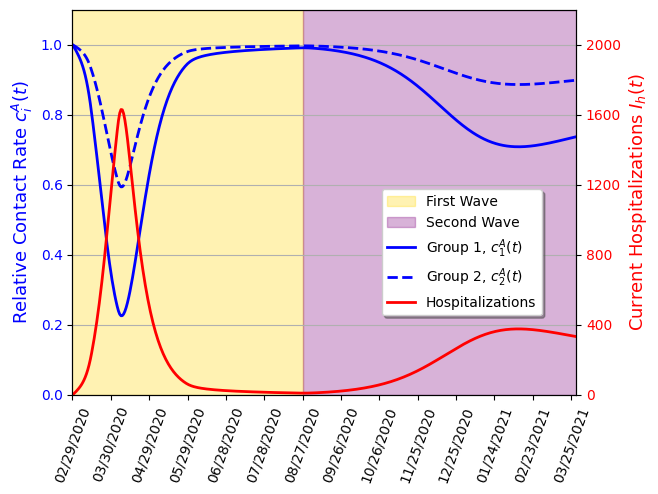

In [10]:
current_hospitalizations_long = np.array(hosp_data['HOSPITALIZED_COUNT'])
current_hospitalizations_long_avgs = [np.mean(current_hospitalizations_long[i-7:i]) for i in range(7,len(current_hospitalizations_long))]

plt.subplot(211)
## plot the data ##
t1 = t_long[7:394+7]
h1 = np.array(current_hospitalizations_long_avgs[:394])
plt.scatter(t1[:-7],h1[:-7], label='NYC COVID-19 hospitalization data',color='red',alpha=0.5,s=10)

## plot model output ##
plt.plot(t_long[:150],H_long[:150],label='Model output',c='blue',linewidth = 2.5)

## plot cross validation ##
plt.plot(t_long[150:394],H_long[150:394],label='Cross validation',c='limegreen',linewidth = 2.5)
# plt.xlim(0,394)

np.savetxt("behaviorhosps.txt", H_long)


current_hospitalizations_long = np.array(hosp_data['HOSPITALIZED_COUNT'])
current_hospitalizations_long_avgs = [np.mean(current_hospitalizations_long[i-7:i]) for i in range(7,len(current_hospitalizations_long))]
np.savetxt("truehosps.txt", current_hospitalizations_long_avgs)
plt.vlines(150,ymin=0,ymax=1750,color='k',linestyle='dashed')
plt.legend(ncol=1, fancybox=True, shadow=True)
plt.ylabel('Daily Hospitalizations',fontsize=11.5)
plt.xticks(t_long[:394:30], dates_long[:394:30],rotation=70)
print(np.max(np.abs(h1[150:310-7]-H_long[157:310])))
print(np.argmax(np.abs(h1[150:310-7]-H_long[157:310])))
print(h1[150:-7][22])
print(H_long[157:394][22])
plt.show()



## plot contact rates ##
plt.rcParams["figure.figsize"] = (6,4.2)
cA1_t = np.exp(-a_1_fit*H_long/N_long)
cA2_t = np.exp(-a_2_fit*H_long/N_long)
plt.axvspan(-10, 150, color='gold', alpha=0.3,label="First Wave") 
plt.axvspan(200, 400, color='purple', alpha=0.3,label="Second Wave") 
H_pop = H_long/N_long
plt.ylabel(r"Relative Contact Rate $c^A_i(t)$",fontsize=13)
plt.plot(t_long[:394],cA1_t[:394],label=r"Group 1, $c^A_1(t)$",linewidth=2,c='blue')
plt.plot(t_long[:394],cA2_t[:394],label=r"Group 2, $c^A_2(t)$",linewidth=2,c='red')
plt.xticks(t_long[:394:30], dates_long[:394:30],rotation=70)
plt.legend(fancybox=True, shadow=True)
# plt.ylim(0,1.1)
num_grid_lines = 11
y_ticks = np.linspace(0, 1, num_grid_lines)
plt.yticks(y_ticks)
plt.grid(axis='y')
plt.show()


# Create the first plot
plt.rcParams["figure.figsize"] = (6.5,5)
fig, ax1 = plt.subplots()
ax1.axvspan(-10, 180, color='gold', alpha=0.3,label="First Wave") 
ax1.axvspan(180, 400, color='purple', alpha=0.3,label="Second Wave")
ax1.plot(t_long[:394],cA1_t[:394],label=r"Group 1, $c^A_1(t)$",linewidth=2,c='blue')
ax1.plot(t_long[:394],cA2_t[:394],label=r"Group 2, $c^A_2(t)$",linewidth=2,c='blue',linestyle='--')
ax1.plot(t_long[400], H_pop[400], color='red', linewidth=2,label='Hospitalizations')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylabel(r"Relative Contact Rate $c^A_i(t)$",fontsize=13,color="blue")
ax1.set_ylim(0,1.1)
ax1.set_xticks(t_long[:394:30], dates_long[:394:30],rotation=70)
ax1.grid(axis='y') 
# ax1.tick_params(axis='y', labelcolor='b')
# Create the second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(t_long[:394], H_long[:394], color='red', linewidth=2,label='Hospitalizations')
ax2.set_ylabel(f'Current Hospitalizations $I_h(t)$', fontsize=13,color='red')
ax2.set_ylim(0,2200)
ax2.set_yticks(np.arange(0,2200,400))
ax2.set_xlim(0,394)
ax2.tick_params(axis='y', labelcolor='r')
ax1.legend(loc='center left', bbox_to_anchor=(0.6, 0.37),fancybox=True, shadow=True)


# Show the plot
plt.show()

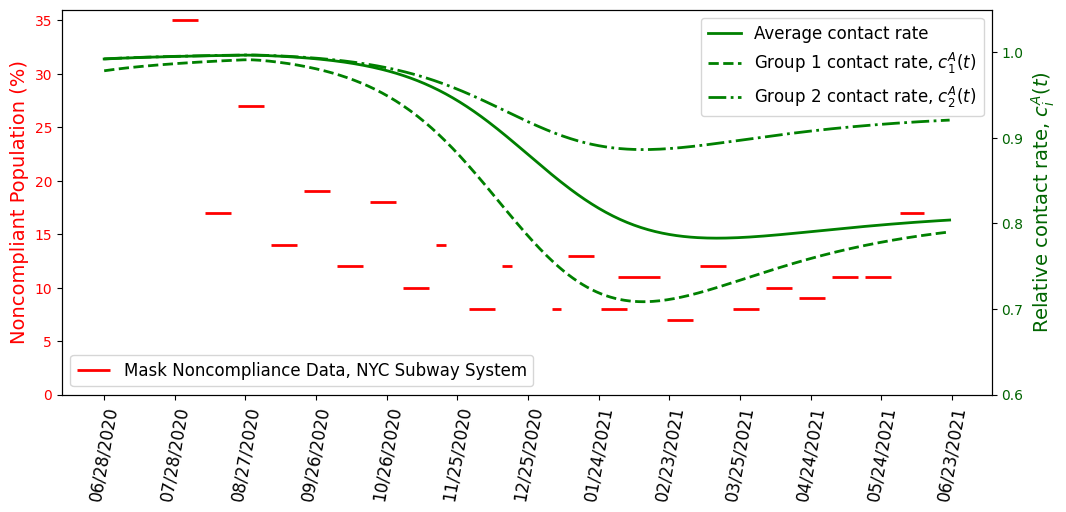

In [10]:
data = pd.read_csv("mask_compliance_nyc.csv")
data = data.rename(columns={'Survey period start date':'start', 
                     'Survey period end date':'end',
                     "Mode":"mode",
                     "No. of observations":"num_obs",
                    "Mask worn correctly":"mask_correct",
                    "Mask worn incorrectly":"mask_incorrect",
                    "No mask":"mask_no",
                    "Total wearing a mask":"mask_total"})
data["start"] = pd.to_datetime(data['start'])
data["end"] = pd.to_datetime(data['end'])
data_sorted = data.sort_values(by='start')
reference_date = pd.to_datetime('2020-02-29')
data_sorted['startday'] = (data_sorted['start'] - reference_date).dt.days
data_sorted['endday'] = (data_sorted['end'] - reference_date).dt.days
plt.rcParams["figure.figsize"] = (8*1.5,5)
mask1 = np.array(data_sorted['mask_correct'])
mask2 = np.array(data_sorted['mask_incorrect']+data_sorted['mask_no'])
maskstart = np.array(data_sorted['startday'])
maskend = np.array(data_sorted['endday'])
fig, ax1 = plt.subplots()
for i,datapoint in enumerate(mask1):
    if maskend[i] < 480:
        ax1.hlines(y=mask2[i], xmin=maskstart[i], xmax=maskend[i], color='r', linewidth=2)
        # plt.hlines(y=mask1[i], xmin=maskstart[i], xmax=maskend[i], color='b', linewidth=2)    
ax1.hlines(y=mask2[0], xmin=maskstart[0], xmax=maskend[0], color='r', linewidth=2,label="Mask Noncompliance Data, NYC Subway System")
ax1.set_xticks(days_long[:490:30],dates_long[:490:30],rotation=80,fontsize=12)
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_ylabel("Noncompliant Population (%)", fontsize=14, color='r')
# ax1.set_title("Mask Non-Compliance on NYC Public Transport and Projected Contact Rate")
ax1.set_ylim(0,36)
ax2 = ax1.twinx()
avgcontact = cA1_t[120:480]*(N1_long/N_long)[120:480] + cA2_t[120:480]*(N2_long/N_long)[120:480]
plt.plot(t_long[120:480],avgcontact,label=r"Average contact rate",linewidth=2,c='green')
ax2.plot(t_long[120:480],cA1_t[120:480],label=r"Group 1 contact rate, $c^A_1(t)$",linewidth=2,c='green',linestyle='--')
ax2.plot(t_long[120:480],cA2_t[120:480],label=r"Group 2 contact rate, $c^A_2(t)$",linewidth=2,c='green',linestyle='dashdot')
ax2.set_ylabel(r"Relative contact rate, $c^A_i(t)$",fontsize=14,c='darkgreen')
ax2.set_ylim(0.6,1.05)
ax2.legend(fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkgreen')
ax1.legend(loc='lower left',fontsize=12)
plt.show()

# Stability Analysis Simulations

In [ ]:
plt.rcParams["figure.figsize"] = (12,7.5)

N0 = 8773000
perturbs = np.random.uniform(low=1e-6, high=10, size=11)
perturbs_on = 1
initial_infections = int(sum(perturbs_on*perturbs))
a_1_fit = 8000
a_2_fit = 4000
c12_fit = 0.25
c21_fit = 0.28
if c12_fit > c21_fit:
    ir = "greater than 1"

if c12_fit < c21_fit:
    ir = "less than 1"

if c12_fit == c21_fit:
    ir = "equal to 1"
    
theta_l1_fit = 1
theta_l2_fit = 1
theta_l3_fit = 1
theta_l4_fit = 1
Beta_a = .1
Beta_i = .05
S1 = 0.5
S2 = 0.5
R0 = theta_l1_fit*(((1-r_1)*Beta_a/Gamma_a)+(r_1*Beta_i/Sigma_i))
print(fr"R0 = {R0}, initial infection size ~ {initial_infections}, influence ratio is {ir}")

for i, k in enumerate([0,0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,1]):
    ics = np.hstack((np.array(k*N0),np.array((1-k)*N0),perturbs_on*perturbs))
    extrayears = 800000
    t_long = np.linspace(0, len(days)+extrayears*365 , len(days)+extrayears*365 + 1, dtype=int)
    sol_long = odeint(full_model, ics, t_long, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
    S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long = sol_long[:,0],sol_long[:,1],sol_long[:,2],sol_long[:,3],sol_long[:,4],sol_long[:,5],sol_long[:,6],sol_long[:,7],sol_long[:,8],sol_long[:,9],sol_long[:,10],sol_long[:,11],sol_long[:,12]
    long_sols = [S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long]
    N1_long = np.sum(long_sols[:-1:2],axis=0)
    N2_long = np.sum(long_sols[1::2],axis=0)
    N_long = N1_long + N2_long

    plt.subplot(3,4,i+1)
    plt.plot(t_long,N1_long/N0,label=r"Group 1",color='blue',linewidth=2)
    plt.plot(t_long,N2_long/N0,label=r"Group 2",color='red',linewidth=2)
    plt.title(f'$k={k}$', fontsize=13)
    plt.ylabel(r"$\frac{N_i(t)}{N_0}$      ", fontsize=13, rotation=0)
    num_grid_lines = 11
    y_ticks = np.linspace(0, 1, num_grid_lines)
    plt.yticks(y_ticks)
    plt.grid(axis='y')
    plt.legend(fancybox=True, shadow=True, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

R0 = 0.78, initial infection size ~ 43, influence ratio is less than 1


# Νumerical Simulations

Questions:
1. What is the impact of behavioral parameters $a_1$ and $a_2$ on pandemic outcomes? Including: peak hospitalizations, cummulative deaths, time between peaks, control reproduction number $R_c$ and endemic equillibrium?
2. Similarly, what is the impact of $c_{12}$ and $c_{21}$?
3. What is the impact of NPIs?

To answer these questions, I need a function that can gather these results from a fitted model.

In [ ]:
k = 0
def model_analysis(params):
    A_1, A_2, C12, C21, Theta_L1, Theta_L2, Theta_L3, Theta_L4 = params
    y0 = np.zeros(13)
    y0[0],y0[1] = k*(N0 - sum(initial_infection_size)), (1-k)*(N0 - sum(initial_infection_size))
    y0[2:12] = initial_infection_size[:-1]
    y0[-1] = initial_infection_size[-1]
    t_long = np.linspace(0, len(days)+1000 , len(days)+1000, dtype=int)
    sol_long = odeint(full_model, y0, t_long, args=(A_1, A_2, C12, C21, Theta_L1, Theta_L2, Theta_L3, Theta_L4))
    S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long = sol_long[:,0],sol_long[:,1],sol_long[:,2],sol_long[:,3],sol_long[:,4],sol_long[:,5],sol_long[:,6],sol_long[:,7],sol_long[:,8],sol_long[:,9],sol_long[:,10],sol_long[:,11],sol_long[:,12]
    long_sols = [S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long]
    
    S_long = S1_long+S2_long
    E_long = E1_long+E2_long
    A_long = A1_long+A2_long
    I_long = I1_long+I2_long
    H_long = H1_long+H2_long
    R_long = R1_long+R2_long

    # peak hospitalizations
    hosp_peaks, _ = find_peaks(H_long)
    hosp_peakday_1, hosp_peakday_2 = hosp_peaks[:2]
    hosp_peakval_1, hosp_peakval_2 = H_long[hosp_peaks[:2]]

    # Defining the end of the waves: a period of 2 weeks where case numbers are relatively constant
    # Find the end of the first wave
    tolerance = 200
    desired_length = 14
    arr1 = np.diff(A_long+I_long)[hosp_peakday_1:]
    wave1_end = None
    for i in range(len(arr1) - desired_length + 1):
        section = arr1[i:i + desired_length]
        if all(abs(x) <= tolerance for x in section):
            wave1_end = i
            break
    # Find the start of the second wave
    wave2_start = None
    for i in range(len(arr1) - desired_length + 1):
        section = arr1[i:i + desired_length]
        if all(x >= 1.5*tolerance for x in section):
            wave2_start = i
            break
    if wave2_start is None:
        print(f'a_1,a_2={a_1,a_2}')
    wave2_start+=hosp_peakday_1
    # Find the end of the second wave
    arr2 = np.diff(A_long+I_long)[hosp_peakday_2:]
    wave2_end = None
    for i in range(len(arr2) - desired_length + 1):
        section = arr2[i:i + desired_length]
        if all(abs(x) <= tolerance for x in section):
            wave2_end = i
            break
    wave2_end+= hosp_peakday_2
    
    # cummulative deaths
    wave1_deaths = D_long[wave1_end]
    wave2_deaths = D_long[wave2_end] - D_long[wave1_end]
    
    # time between peaks
    time_between_peaks = hosp_peakday_2 - hosp_peakday_1

    # endemic equillibrium
    endem_equil = np.array((A_long+I_long)/N0)[-1]
    
    return hosp_peakday_1, hosp_peakday_2, hosp_peakval_1, hosp_peakval_2, wave1_end, wave2_start, wave2_end, wave1_deaths, wave2_deaths, time_between_peaks, endem_equil

hosp_peakday_1, hosp_peakday_2, hosp_peakval_1, hosp_peakval_2, wave1_end, wave2_start, wave2_end, wave1_deaths, wave2_deaths, time_between_peaks,endem_equil = model_analysis((a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit,theta_l2_fit,theta_l3_fit,theta_l4_fit))



## Impact of $a_i$ (contour)

In [134]:
max_a = 8000
n_a_1 = 100
n_a_2 = 100
a_1_arr = np.linspace(0,500+max_a,n_a_1)
a_2_arr = np.linspace(0,max_a-500,n_a_2)
W1_peakhosps_vals = np.inf*np.ones((n_a_1,n_a_2))
W2_peakhosps_vals = np.inf*np.ones((n_a_1,n_a_2))
W2_len_vals = np.inf*np.ones((n_a_1,n_a_2))
W1_deaths_vals = np.inf*np.ones((n_a_1,n_a_2))
W2_deaths_vals = np.inf*np.ones((n_a_1,n_a_2))
Endem_Equil_vals = np.inf*np.ones((n_a_1,n_a_2))
TBP_vals = np.inf*np.ones((n_a_1,n_a_2))

W1_peakhosps_vals1 = np.inf*np.ones((n_a_1,n_a_2))
W2_peakhosps_vals1 = np.inf*np.ones((n_a_1,n_a_2))
W2_len_vals1 = np.inf*np.ones((n_a_1,n_a_2))
W1_deaths_vals1 = np.inf*np.ones((n_a_1,n_a_2))
W2_deaths_vals1 = np.inf*np.ones((n_a_1,n_a_2))
Endem_Equil_vals1 = np.inf*np.ones((n_a_1,n_a_2))
TBP_vals1 = np.inf*np.ones((n_a_1,n_a_2))

for i,a_1 in enumerate(tqdm(a_1_arr)):
    for j,a_2 in enumerate(a_2_arr):
        if a_2<=a_1:
            hosp_peakday_1, hosp_peakday_2, hosp_peakval_1, hosp_peakval_2, wave1_end, wave2_start, wave2_end, wave1_deaths, wave2_deaths, time_between_peaks, endem_equil = model_analysis((a_1, a_2, c12_fit, c21_fit, beta_a_fit, beta_i_fit, r_2_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
            W1_peakhosps_vals[i,j] = hosp_peakval_1
            W2_peakhosps_vals[i,j]=hosp_peakval_2
            W2_len_vals[i,j]=wave2_end-wave2_start
            W1_deaths_vals[i,j]=wave1_deaths
            W2_deaths_vals[i,j]=wave2_deaths
            # Endem_Equil_vals[i,j]=endem_equil
            TBP_vals[i,j]=time_between_peaks

100%|█████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


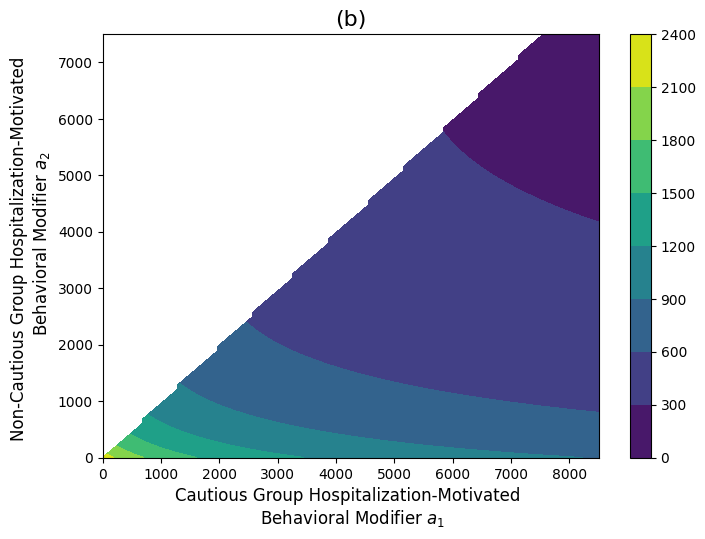

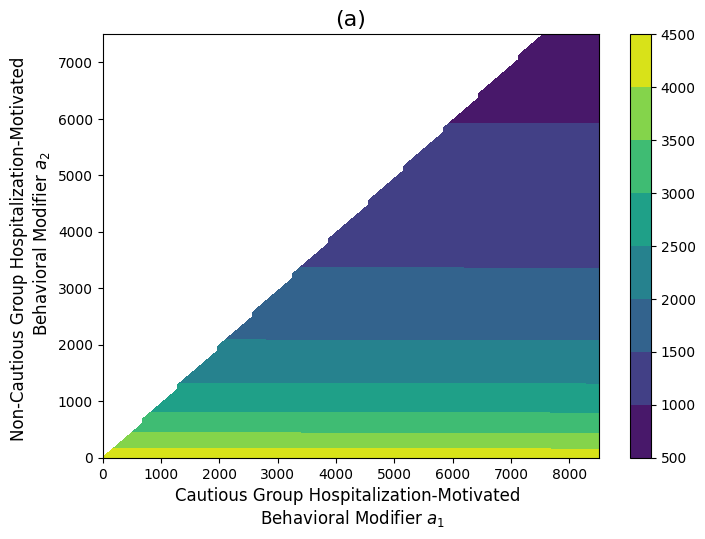

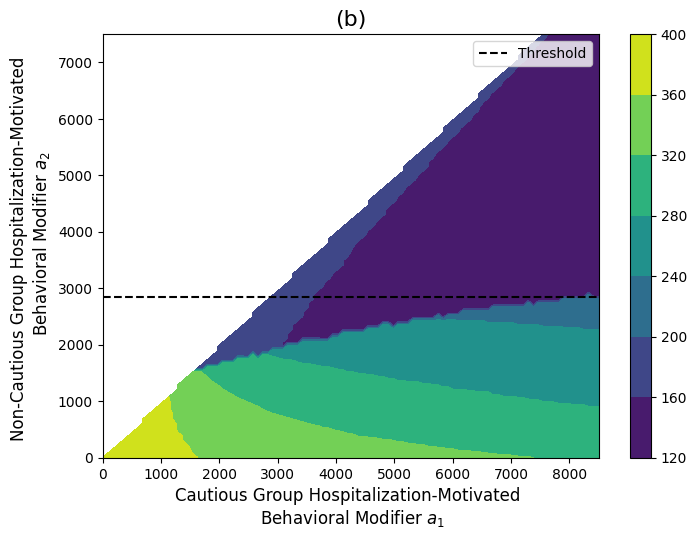

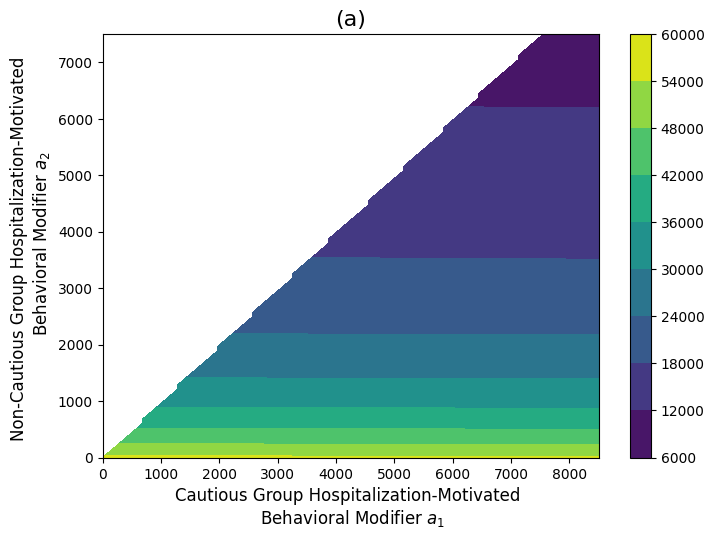

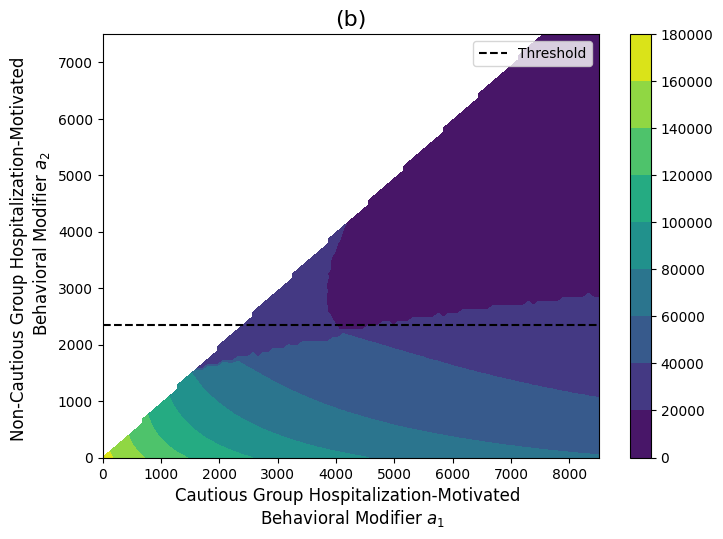

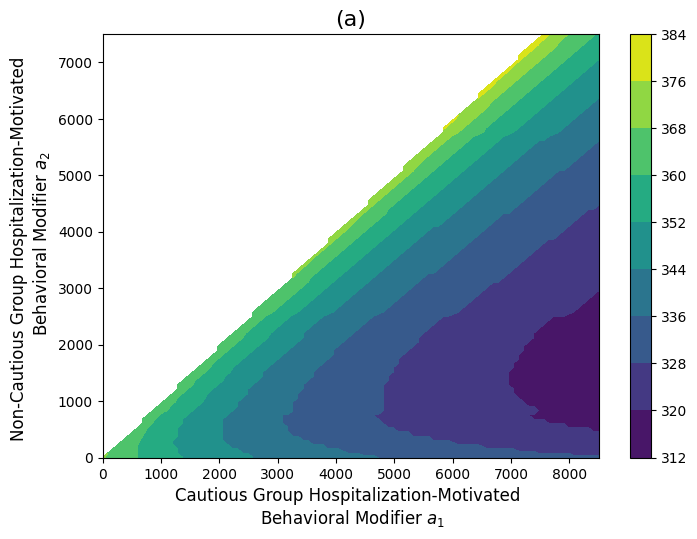

In [136]:
plt.contourf(a_1_arr,a_2_arr,W2_peakhosps_vals.T)
plt.xlabel(f'Cautious Group Hospitalization-Motivated \n Behavioral Modifier $a_1$', fontsize=12)
plt.ylabel(f'Non-Cautious Group Hospitalization-Motivated \n Behavioral Modifier $a_2$', fontsize=12)
plt.title('(b)',fontsize=16)
plt.colorbar()#.set_label('Wave 2 Peak Hospitalizations', fontsize=14, labelpad=10)
# plt.title(r'$c_{12}=\frac{1}{30}$, $c_{21}=\frac{1}{90}$')
# plt.suptitle(r'Impact of $a_i$ Values on Second Wave Peak Hospitalization')
plt.show()


plt.contourf(a_1_arr,a_2_arr,W1_peakhosps_vals.T)
plt.xlabel(f'Cautious Group Hospitalization-Motivated \n Behavioral Modifier $a_1$', fontsize=12)
plt.ylabel(f'Non-Cautious Group Hospitalization-Motivated \n Behavioral Modifier $a_2$', fontsize=12)
plt.colorbar()#.set_label('Wave 2 Peak Hospitalizations', fontsize=14, labelpad=10)
# plt.title(r'$c_{12}=\frac{1}{30}$, $c_{21}=\frac{1}{90}$')
# plt.suptitle(r'Impact of $a_i$ Values on First Wave Peak Hospitalization')
plt.title('(a)',fontsize=16)
plt.show()


plt.contourf(a_1_arr,a_2_arr,W2_len_vals.T)
plt.hlines(2850,xmin=0,xmax=8500,color='k',linestyle='dashed',label='Threshold')
plt.xlabel(f'Cautious Group Hospitalization-Motivated \n Behavioral Modifier $a_1$', fontsize=12)
plt.ylabel(f'Non-Cautious Group Hospitalization-Motivated \n Behavioral Modifier $a_2$', fontsize=12)
plt.title('(b)',fontsize=16)
plt.colorbar()#.set_label('Wave 2 Peak Hospitalizations', fontsize=14, labelpad=10)
# plt.title(r'$c_{12}=\frac{1}{30}$, $c_{21}=\frac{1}{90}$')
# plt.suptitle(r'Impact of $a_i$ Values on Second Wave Length')
plt.legend()
plt.show()


plt.contourf(a_1_arr,a_2_arr,W1_deaths_vals.T)
plt.xlabel(f'Cautious Group Hospitalization-Motivated \n Behavioral Modifier $a_1$', fontsize=12)
plt.ylabel(f'Non-Cautious Group Hospitalization-Motivated \n Behavioral Modifier $a_2$', fontsize=12)
plt.title('(a)',fontsize=16)
plt.colorbar()#.set_label('Wave 2 Peak Hospitalizations', fontsize=14, labelpad=10)
# plt.title(r'$c_{12}=\frac{1}{30}$, $c_{21}=\frac{1}{90}$')
# plt.suptitle(r'Impact of $a_i$ Values on First Wave Cumulative Deaths')
plt.show()


plt.contourf(a_1_arr,a_2_arr,W2_deaths_vals.T)
plt.xlabel(f'Cautious Group Hospitalization-Motivated \n Behavioral Modifier $a_1$', fontsize=12)
plt.ylabel(f'Non-Cautious Group Hospitalization-Motivated \n Behavioral Modifier $a_2$', fontsize=12)
plt.title('(b)',fontsize=16)
plt.hlines(2350,xmin=0,xmax=8500,color='k',linestyle='dashed',label='Threshold')
plt.colorbar()#.set_label('Wave 2 Peak Hospitalizations', fontsize=14, labelpad=10)
# plt.title(r'$c_{12}=\frac{1}{30}$, $c_{21}=\frac{1}{90}$')
plt.legend()
# plt.suptitle(r'Impact of $a_i$ Values on Second Wave Cumulative Deaths')
plt.show()

plt.contourf(a_1_arr,a_2_arr,TBP_vals.T)
plt.xlabel(f'Cautious Group Hospitalization-Motivated \n Behavioral Modifier $a_1$', fontsize=12)
plt.ylabel(f'Non-Cautious Group Hospitalization-Motivated \n Behavioral Modifier $a_2$', fontsize=12)
plt.title('(a)',fontsize=16)
plt.colorbar()#.set_label('Wave 2 Peak Hospitalizations', fontsize=14, labelpad=10)
# plt.title(r'$c_{12}=\frac{1}{30}$, $c_{21}=\frac{1}{90}$')
# plt.suptitle(r'Impact of $a_i$ Values on Time Between Peaks')
plt.show()

## Impact of $c_{ij}$s, contour

In [63]:
max_c = 30
n_c_12 = 100
n_c_21 = 30
c_12_arr = np.linspace(1,max_c,n_c_12)
c_21_arr = np.linspace(1,max_c,n_c_21)
W1_peakhosps_vals = np.inf*np.ones((n_c_12,n_c_21))
W2_peakhosps_vals = np.inf*np.ones((n_c_12,n_c_21))
W2_len_vals = np.inf*np.ones((n_c_12,n_c_21))
W1_deaths_vals = np.inf*np.ones((n_c_12,n_c_21))
W2_deaths_vals = np.inf*np.ones((n_c_12,n_c_21))
Endem_Equil_vals = np.inf*np.ones((n_c_12,n_c_21))
TBP_vals = np.inf*np.ones((n_c_12,n_c_21))

for i,c_12 in enumerate(tqdm(c_12_arr)):
    for j,c_21 in enumerate(c_21_arr):
        hosp_peakday_1, hosp_peakday_2, hosp_peakval_1, hosp_peakval_2, wave1_end, wave2_start, wave2_end, wave1_deaths, wave2_deaths, time_between_peaks, endem_equil = model_analysis((a_1_fit, a_2_fit, 1/c_12, 1/c_21, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
        W1_peakhosps_vals[i,j] = hosp_peakval_1
        W2_peakhosps_vals[i,j]=hosp_peakval_2
        W2_len_vals[i,j]=wave2_end-wave2_start
        W1_deaths_vals[i,j]=wave1_deaths
        W2_deaths_vals[i,j]=wave2_deaths
        # Endem_Equil_vals[i,j]=endem_equil
        TBP_vals[i,j]=time_between_peaks

100%|█████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


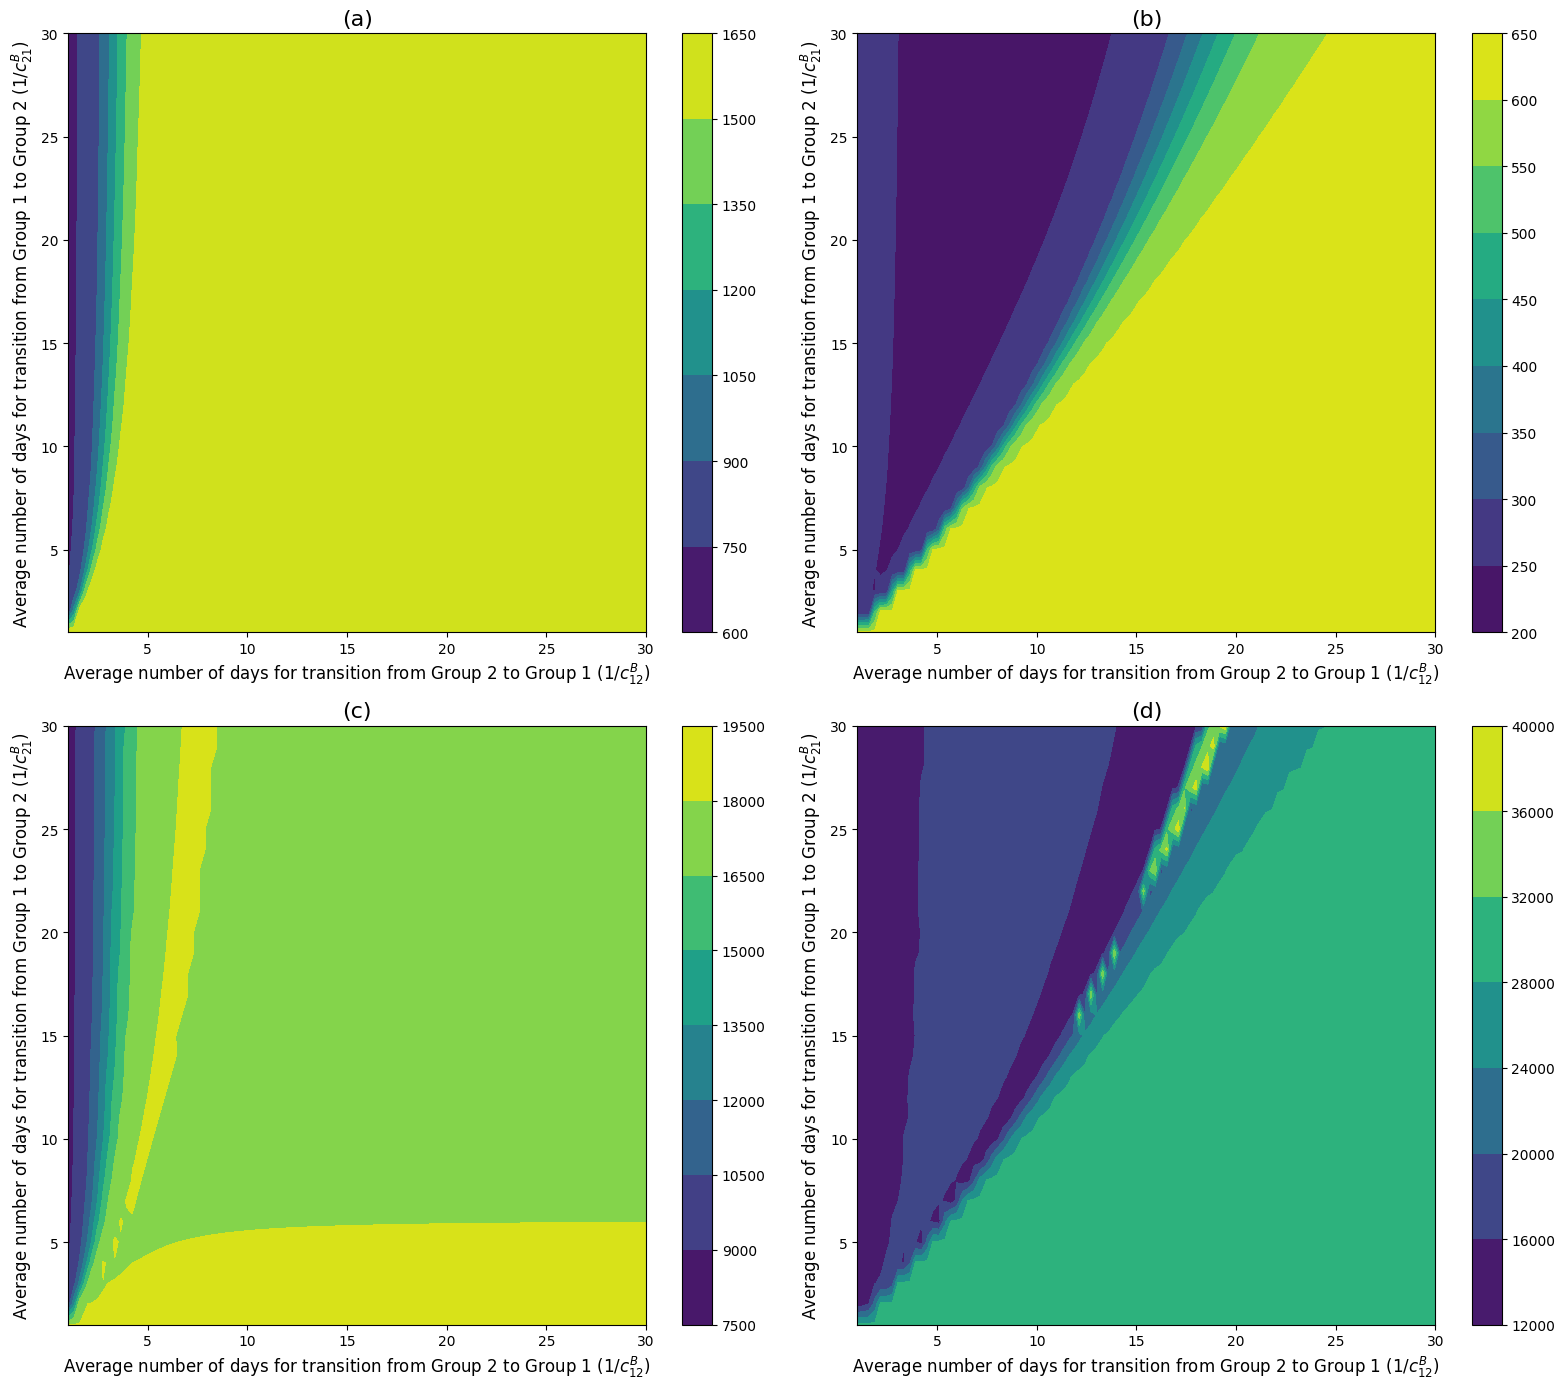

In [65]:
plt.rcParams["figure.figsize"] = (16,14)
plt.subplot(221)
plt.title("(a)",fontsize=16)
plt.contourf(c_12_arr,c_21_arr,W1_peakhosps_vals.T)
plt.xlabel(r'Average number of days for transition from Group 2 to Group 1 $(1/c^B_{12})$',fontsize=12)
plt.ylabel(r'Average number of days for transition from Group 1 to Group 2 $(1/c^B_{21})$',fontsize=12)
plt.colorbar()#.set_label('Wave 1 Peak Hospitalizations', fontsize=14, labelpad=10)

plt.subplot(222)
plt.title("(b)",fontsize=16)
plt.contourf(c_12_arr,c_21_arr,W2_peakhosps_vals.T)
plt.xlabel(r'Average number of days for transition from Group 2 to Group 1 $(1/c^B_{12})$',fontsize=12)
plt.ylabel(r'Average number of days for transition from Group 1 to Group 2 $(1/c^B_{21})$',fontsize=12)
plt.colorbar()#.set_label('Wave 2 Peak Hospitalizations', fontsize=14, labelpad=10)
# plt.title(r'Impact of $c_{ij}$ Values on Second Wave Peak Hospitalization')


plt.subplot(223)
plt.title("(c)",fontsize=16)
plt.contourf(c_12_arr,c_21_arr,W1_deaths_vals.T)
plt.xlabel(r'Average number of days for transition from Group 2 to Group 1 $(1/c^B_{12})$',fontsize=12)
plt.ylabel(r'Average number of days for transition from Group 1 to Group 2 $(1/c^B_{21})$',fontsize=12)
plt.colorbar()#.set_label('Wave 1 Cumulative Deaths', fontsize=14, labelpad=10)
# plt.title(r'Impact of $c_{ij}$ Values on First Wave Cumulative Deaths')

plt.subplot(224)
plt.title("(d)",fontsize=16)
plt.contourf(c_12_arr,c_21_arr,W2_deaths_vals.T)
plt.xlabel(r'Average number of days for transition from Group 2 to Group 1 $(1/c^B_{12})$',fontsize=12)
plt.ylabel(r'Average number of days for transition from Group 1 to Group 2 $(1/c^B_{21})$',fontsize=12)
plt.colorbar()#.set_label('Wave 2 Cumulative Deaths', fontsize=14, labelpad=10)
# plt.title(r'Impact of $c_{ij}$ Values on Second Wave Cumulative Deaths')
plt.tight_layout()
plt.show()

# plt.contourf(c_12_arr,c_21_arr,TBP_vals.T)
# plt.xlabel(r'Days till people become cautious $1/c_{12}$')
# plt.ylabel(r'Days till people become non-cautious $1/c_{21}$')
# plt.colorbar()#.set_label('Time Between Peaks (days)', fontsize=14, labelpad=10)
# plt.title(r'Impact of $c_{ij}$ Values on Time Between Peaks')
# # plt.title('(a)',fontsize=16)
# plt.show()

# plt.contourf(c_12_arr,c_21_arr,W2_len_vals.T)
# plt.xlabel(r'Days till people become cautious $1/c_{12}$',fontsize=12)
# plt.ylabel(r'Days till people become non-cautious $1/c_{21}$',fontsize=12)
# plt.colorbar()#.set_label('Second Wave Length (days)', fontsize=14, labelpad=10)
# plt.title(r'Impact of $c_{ij}$ Values on Second Wave Length')
# # plt.title('(b)',fontsize=16)
# plt.show()

## Impact of $c_{ij}$'s: The ratio $\frac{c_{12}}{c_{21}}$

100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.79it/s]


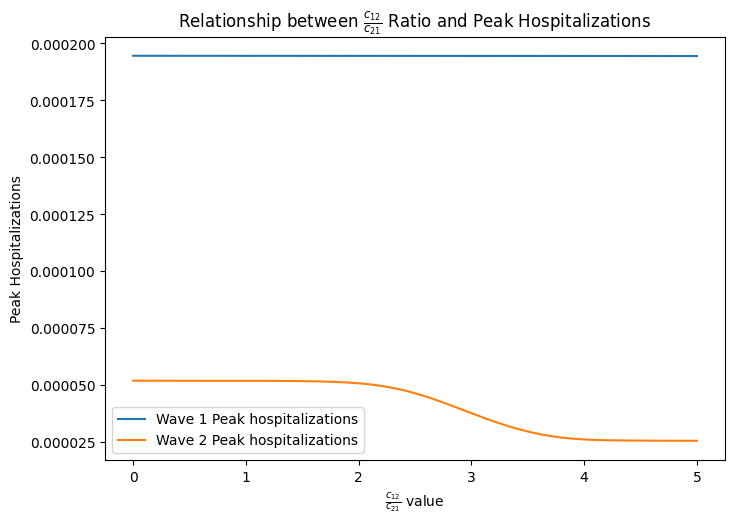

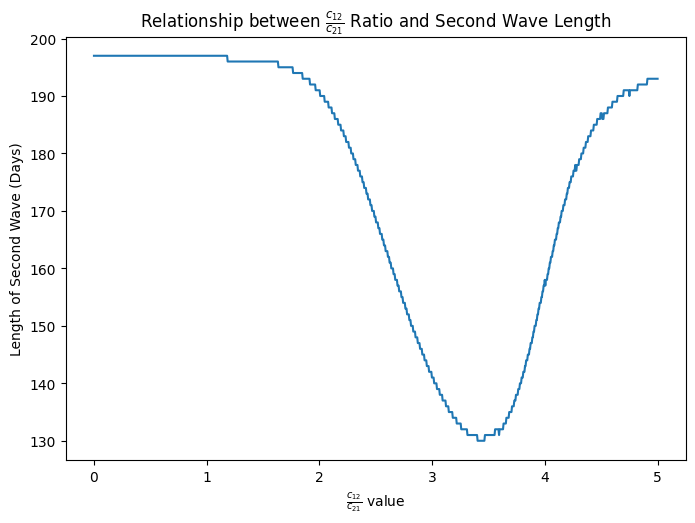

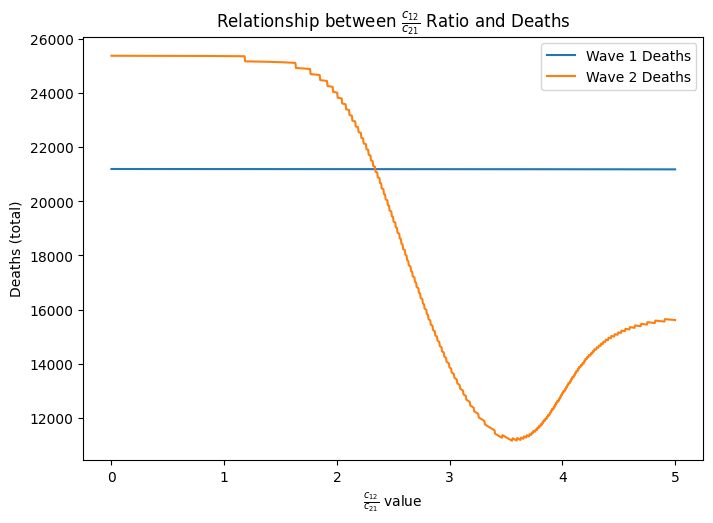

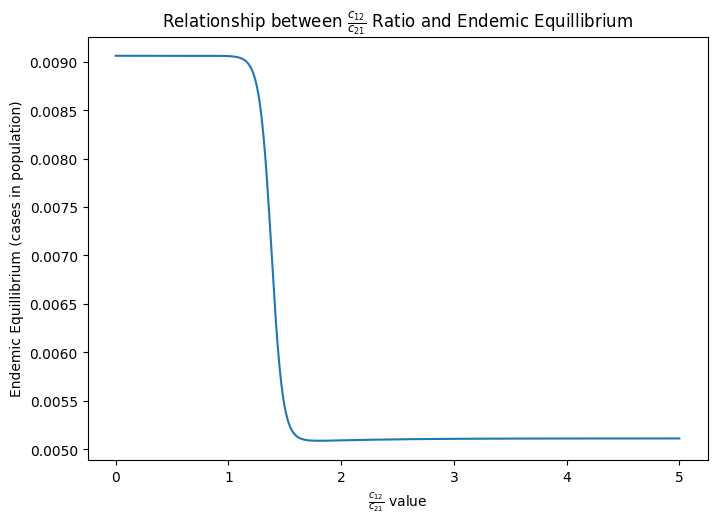

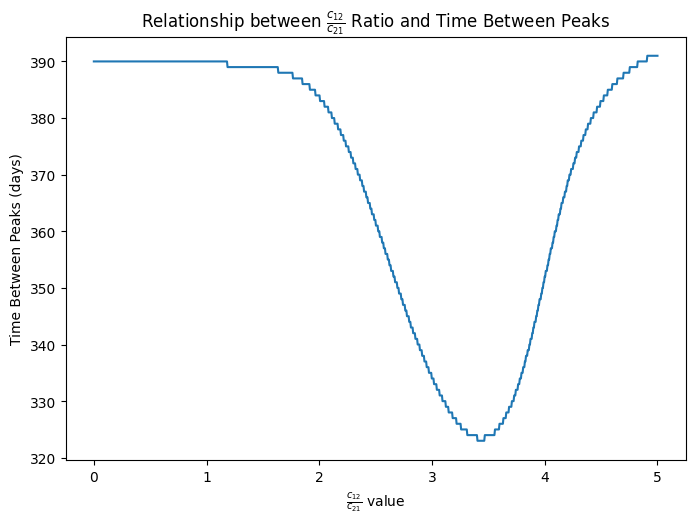

In [34]:
W1_peakhosps = []
W2_peakhosps = []
W2_len = []
W1_deaths = []
W2_deaths = []
Endem_Equil = []
TBP = []
max_a = a_1_fit
c_ratio_arr = np.linspace(0,5,1000)
for ratio in tqdm(c_ratio_arr):
    hosp_peakday_1, hosp_peakday_2, hosp_peakval_1, hosp_peakval_2, wave1_end, wave2_start, wave2_end, wave1_deaths, wave2_deaths, time_between_peaks,endem_equil = model_analysis((a_1_fit, a_2_fit, c21_fit*ratio, c21_fit, beta_a_fit, beta_i_fit, r_2_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
    W1_peakhosps.append(hosp_peakval_1)
    W2_peakhosps.append(hosp_peakval_2)
    W2_len.append(wave2_end-wave2_start)
    W1_deaths.append(wave1_deaths)
    W2_deaths.append(wave2_deaths)
    Endem_Equil.append(endem_equil)
    TBP.append(time_between_peaks)

plt.plot(c_ratio_arr,np.array(W1_peakhosps)/N0,label = r'Wave 1 Peak hospitalizations')
plt.plot(c_ratio_arr,np.array(W2_peakhosps)/N0,label = 'Wave 2 Peak hospitalizations')
plt.legend()
plt.xlabel(r"$\frac{c_{12}}{c_{21}}$ value")
plt.ylabel("Peak Hospitalizations")
plt.title(r"Relationship between $\frac{c_{12}}{c_{21}}$ Ratio and Peak Hospitalizations")
plt.show()

plt.plot(c_ratio_arr,W2_len)
plt.xlabel(r"$\frac{c_{12}}{c_{21}}$ value")
plt.ylabel("Length of Second Wave (Days)")
plt.title(r"Relationship between $\frac{c_{12}}{c_{21}}$ Ratio and Second Wave Length")
plt.show()

plt.plot(c_ratio_arr,W1_deaths, label='Wave 1 Deaths')
plt.plot(c_ratio_arr,W2_deaths, label='Wave 2 Deaths')
plt.legend()
plt.xlabel(r"$\frac{c_{12}}{c_{21}}$ value")
plt.ylabel("Deaths (total)")
plt.title(r"Relationship between $\frac{c_{12}}{c_{21}}$ Ratio and Deaths")
plt.show()

plt.plot(c_ratio_arr,Endem_Equil)
plt.xlabel(r"$\frac{c_{12}}{c_{21}}$ value")
plt.ylabel("Endemic Equillibrium (cases in population)")
plt.title(r"Relationship between $\frac{c_{12}}{c_{21}}$ Ratio and Endemic Equillibrium")
plt.show()

plt.plot(c_ratio_arr,TBP)
plt.xlabel(r"$\frac{c_{12}}{c_{21}}$ value")
plt.ylabel("Time Between Peaks (days)")
plt.title(r"Relationship between $\frac{c_{12}}{c_{21}}$ Ratio and Time Between Peaks")
plt.show()

# $\mathbb{R}_0$ Sims

we want plots showing as a function of time:
- total number of infected individuals
- new cases
for two values of $\mathbb{R}_0$, one greater than 0, one less than 0.

We want these plots for at ~8 different ics

## $\mathbb{R}_0<1$

In [23]:
## Different ICs ##
plt.rcParams["figure.figsize"] = (3*4.5,7.5)
N0 = 8773000
IIS_reg = np.array([4000,4000,750,750,1500,1500,0,0,0,0,0])
mults = np.random.uniform(0.2,3,8)
ICS = [mult*IIS_reg for mult in mults]

R0 = 0.78


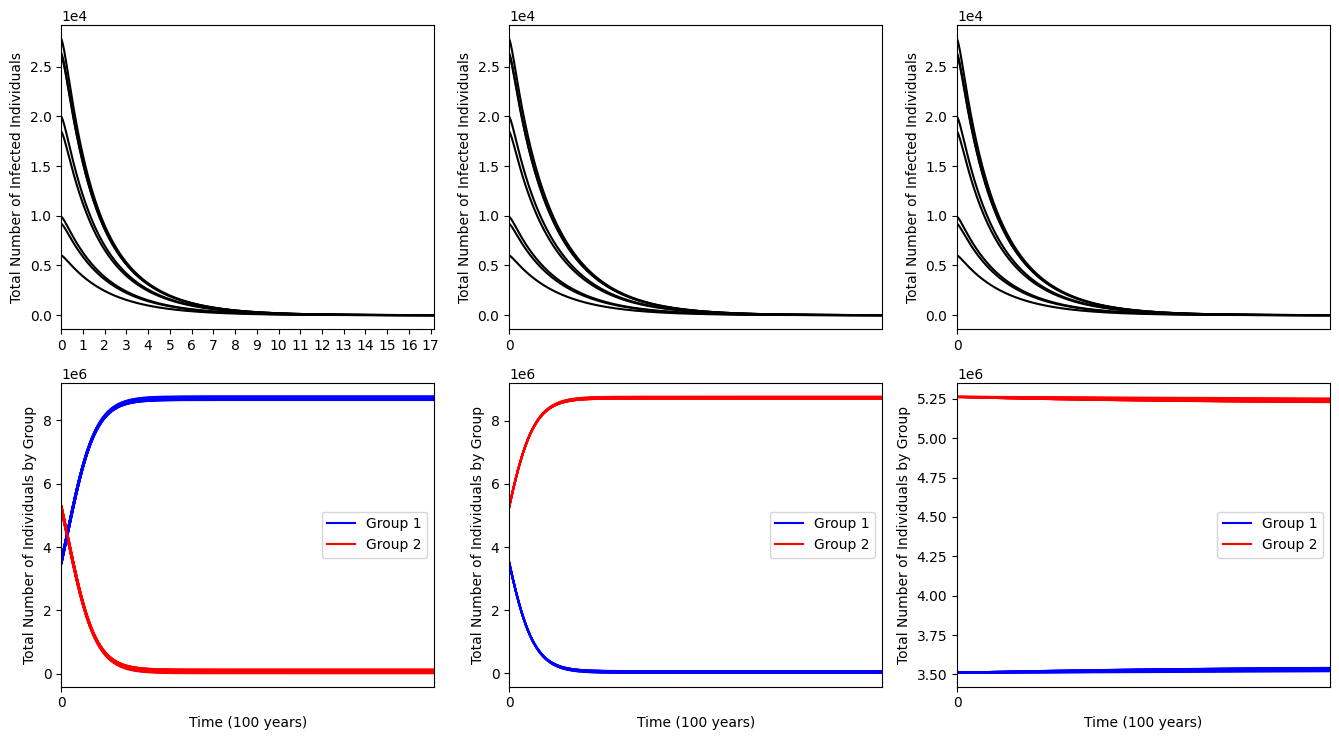

In [11]:
a_1_fit = result.params['a_1'].value
a_2_fit = result.params['a_2'].value
# c12_fit = result.params['c12'].value
# c21_fit = result.params['c21'].value
c12_fit = 0.3
c21_fit = 0.25
theta_l1_fit = 1
theta_l2_fit = 1
theta_l3_fit = 1
theta_l4_fit = 1
Beta_a = .1
Beta_i = .05
S1 = 2
S2 = 0
N = S1 + S2
alpha1 = c12_fit*S1/N
alpha2 = c21_fit*S2/N
Emat = np.array([[-Sigma_e-alpha2,alpha1],[alpha2, -Sigma_e-alpha1]])
Amat = np.array([[-Gamma_a-alpha2,alpha1],[alpha2, -Gamma_a-alpha1]])
Smat = np.array([[-Sigma_i-alpha2,alpha1],[alpha2, -Sigma_i-alpha1]])
Einv, Ainv, Sinv = np.linalg.inv(Emat), np.linalg.inv(Amat),np.linalg.inv(Smat)
Fa = np.array([[S1/N*Beta_a,S1/N*Beta_a],[S2/N*Beta_a,S2/N*Beta_a]])
Fs = np.array([[S1/N*Beta_i,S1/N*Beta_i],[S2/N*Beta_i,S2/N*Beta_i]])
K11 = -(1-r_1)*Sigma_e*Fa@Ainv@Einv-Sigma_e*r_1*Fs@Sinv@Einv
R0 = theta_l3_fit*max(np.abs(np.linalg.eigvals(K11)))
print(f"R0 = {R0}")

for ic in ICS:
    y0 = np.zeros(13)
    y0[0],y0[1] = 0.4*(N0 - sum(ic)), 0.6*(N0 - sum(ic))
    y0[2:12] = ic[:-1]
    y0[-1] = ic[-1]
    extrayears = 1
    t_long = np.linspace(0, len(days)+int(extrayears*365) , len(days)+int(extrayears*365) + 1, dtype=int)
    sol_long = odeint(full_model, y0, t_long, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
    S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long = sol_long[:,0],sol_long[:,1],sol_long[:,2],sol_long[:,3],sol_long[:,4],sol_long[:,5],sol_long[:,6],sol_long[:,7],sol_long[:,8],sol_long[:,9],sol_long[:,10],sol_long[:,11],sol_long[:,12]
    long_sols = [S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long]
    
    # plot total # of infected individuals wrt time
    plt.subplot(231)
    total_infected = (E1_long+E2_long+A1_long+A2_long+I1_long+I2_long+H1_long+H2_long)
    plt.plot(t_long,total_infected,c='k')
    plt.ticklabel_format(axis='y', style='sci',scilimits=(4,4))
    plt.ylabel("Total Number of Infected Individuals")
    plt.xlim(0,t_long[-1])
    plt.xticks(t_long[:-1:30], np.arange(0,len(t_long[:-1:30])))
    # plt.xlabel("Time (days)")
    
    plt.subplot(234)
    N1_long = np.sum(long_sols[:-1:2],axis=0)
    N2_long = np.sum(long_sols[1::2],axis=0)
    plt.plot(t_long,N1_long,c='blue',linewidth=2)
    plt.plot(t_long,N2_long,c='red',linewidth=2)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
    # plt.ylim(3e6,5.5e6)
    plt.ylabel("Total Number of Individuals by Group")
    plt.xlim(0,t_long[-1])
    plt.xticks(t_long[:-1:36500], np.arange(0,len(t_long[:-1:36500])))
    plt.xlabel("Time (100 years)")
plt.plot(t_long,N1_long,c='blue', label='Group 1')
plt.plot(t_long,N2_long,c='red', label='Group 2')
plt.legend()

c12_fit = 0.25
c21_fit = 0.3
for ic in ICS:
    y0 = np.zeros(13)
    y0[0],y0[1] = 0.4*(N0 - sum(ic)), 0.6*(N0 - sum(ic))
    y0[2:12] = ic[:-1]
    y0[-1] = ic[-1]
    extrayears = 1
    t_long = np.linspace(0, len(days)+int(extrayears*365) , len(days)+int(extrayears*365) + 1, dtype=int)
    sol_long = odeint(full_model, y0, t_long, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
    S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long = sol_long[:,0],sol_long[:,1],sol_long[:,2],sol_long[:,3],sol_long[:,4],sol_long[:,5],sol_long[:,6],sol_long[:,7],sol_long[:,8],sol_long[:,9],sol_long[:,10],sol_long[:,11],sol_long[:,12]
    long_sols = [S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long]
    
    # plot total # of infected individuals wrt time
    plt.subplot(232)
    total_infected = (E1_long+E2_long+A1_long+A2_long+I1_long+I2_long+H1_long+H2_long)
    plt.plot(t_long,total_infected,c='k')
    plt.ticklabel_format(axis='y', style='sci',scilimits=(4,4))
    plt.ylabel("Total Number of Infected Individuals")
    plt.xlim(0,t_long[-1])
    plt.xticks(t_long[:-1:36500], np.arange(0,len(t_long[:-1:36500])))
    
    plt.subplot(235)
    N1_long = np.sum(long_sols[:-1:2],axis=0)
    N2_long = np.sum(long_sols[1::2],axis=0)
    plt.plot(t_long,N1_long,c='blue')
    plt.plot(t_long,N2_long,c='red')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
    # plt.ylim(3e6,5.5e6)
    plt.ylabel("Total Number of Individuals by Group")
    plt.xlim(0,t_long[-1])
    plt.xticks(t_long[:-1:36500], np.arange(0,len(t_long[:-1:36500])))
    plt.xlabel("Time (100 years)")

plt.plot(t_long,N1_long,c='blue', label='Group 1')
plt.plot(t_long,N2_long,c='red', label='Group 2')
plt.legend()

c12_fit = 0.25
c21_fit = 0.25
for ic in ICS:
    y0 = np.zeros(13)
    y0[0],y0[1] = 0.4*(N0 - sum(ic)), 0.6*(N0 - sum(ic))
    y0[2:12] = ic[:-1]
    y0[-1] = ic[-1]
    extrayears = 1
    t_long = np.linspace(0, len(days)+int(extrayears*365) , len(days)+int(extrayears*365) + 1, dtype=int)
    sol_long = odeint(full_model, y0, t_long, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
    S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long = sol_long[:,0],sol_long[:,1],sol_long[:,2],sol_long[:,3],sol_long[:,4],sol_long[:,5],sol_long[:,6],sol_long[:,7],sol_long[:,8],sol_long[:,9],sol_long[:,10],sol_long[:,11],sol_long[:,12]
    long_sols = [S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long]

    # plot total # of infected individuals wrt time
    plt.subplot(233)
    total_infected = (E1_long+E2_long+A1_long+A2_long+I1_long+I2_long+H1_long+H2_long)
    plt.plot(t_long,total_infected,c='k')
    plt.ticklabel_format(axis='y', style='sci',scilimits=(4,4))
    plt.ylabel("Total Number of Infected Individuals")
    plt.xlim(0,t_long[-1])
    plt.xticks(t_long[:-1:36500], np.arange(0,len(t_long[:-1:36500])))
    
    plt.subplot(236)
    N1_long = np.sum(long_sols[:-1:2],axis=0)
    N2_long = np.sum(long_sols[1::2],axis=0)
    plt.plot(t_long,N1_long,c='blue')
    plt.plot(t_long,N2_long,c='red')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
    # plt.ylim(3e6,5.5e6)
    plt.ylabel("Total Number of Individuals by Group")
    plt.xlim(0,t_long[-1])
    plt.xticks(t_long[:-1:36500], np.arange(0,len(t_long[:-1:36500])))
    plt.xlabel("Time (100 years)")

    
plt.plot(t_long,N1_long,c='blue', label='Group 1')
plt.plot(t_long,N2_long,c='red', label='Group 2')
plt.legend()
plt.tight_layout()
plt.show()

## $\mathbb{R}_0>1$

0 0.005555555555555556
R0 = 7.800000000000001


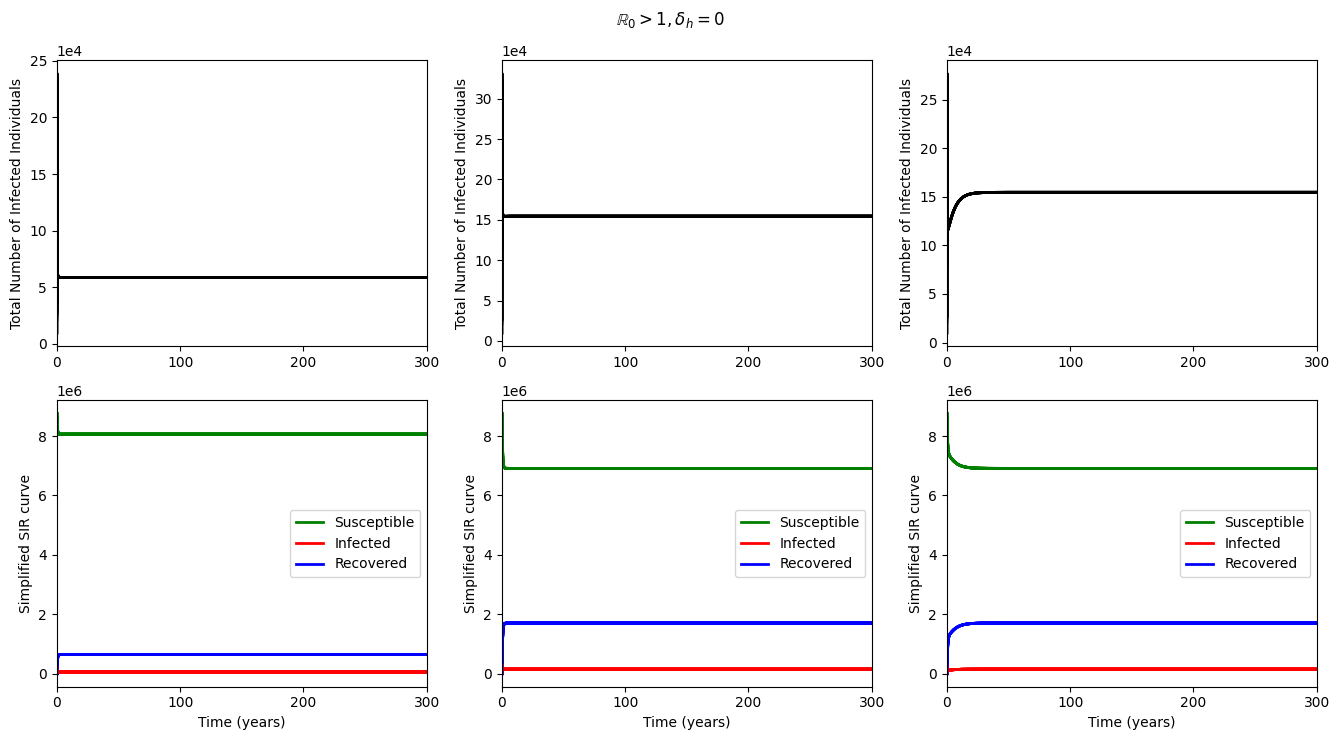

In [45]:
a_1_fit = result.params['a_1'].value
a_2_fit = result.params['a_2'].value
print(Delta_h,Xi)
# c12_fit = result.params['c12'].value
# c21_fit = result.params['c21'].value
c12_fit = 0.3
c21_fit = 0.25
theta_l1_fit = 1
theta_l2_fit = 1
theta_l3_fit = 1
theta_l4_fit = 1
Beta_a = 1
Beta_i = .5
S1 = 2
S2 = 0
N = S1 + S2
alpha1 = c12_fit*S1/N
alpha2 = c21_fit*S2/N
Emat = np.array([[-Sigma_e-alpha2,alpha1],[alpha2, -Sigma_e-alpha1]])
Amat = np.array([[-Gamma_a-alpha2,alpha1],[alpha2, -Gamma_a-alpha1]])
Smat = np.array([[-Sigma_i-alpha2,alpha1],[alpha2, -Sigma_i-alpha1]])
Einv, Ainv, Sinv = np.linalg.inv(Emat), np.linalg.inv(Amat),np.linalg.inv(Smat)
Fa = np.array([[S1/N*Beta_a,S1/N*Beta_a],[S2/N*Beta_a,S2/N*Beta_a]])
Fs = np.array([[S1/N*Beta_i,S1/N*Beta_i],[S2/N*Beta_i,S2/N*Beta_i]])
K11 = -(1-r_1)*Sigma_e*Fa@Ainv@Einv-Sigma_e*r_1*Fs@Sinv@Einv
R0 = theta_l3_fit*max(np.abs(np.linalg.eigvals(K11)))
print(f"R0 = {R0}")

for ic in ICS:
    y0 = np.zeros(13)
    y0[0],y0[1] = 0.4*(N0 - sum(ic)), 0.6*(N0 - sum(ic))
    y0[2:12] = ic[:-1]
    y0[-1] = ic[-1]
    extrayears = 300
    t_long = np.linspace(0, len(days)+int(extrayears*365) , len(days)+int(extrayears*365) + 1, dtype=int)
    sol_long = odeint(full_model, y0, t_long, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
    S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long = sol_long[:,0],sol_long[:,1],sol_long[:,2],sol_long[:,3],sol_long[:,4],sol_long[:,5],sol_long[:,6],sol_long[:,7],sol_long[:,8],sol_long[:,9],sol_long[:,10],sol_long[:,11],sol_long[:,12]
    long_sols = [S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long]
    
    # plot total # of infected individuals wrt time
    plt.subplot(231)
    total_infected = (E1_long+E2_long+A1_long+A2_long+I1_long+I2_long+H1_long+H2_long)
    plt.plot(t_long,total_infected,c='k',linewidth=2)
    plt.ticklabel_format(axis='y', style='sci',scilimits=(4,4))
    plt.ylabel("Total Number of Infected Individuals")
    plt.xlim(0,t_long[-1])
    plt.xticks(t_long[:-1:365], np.arange(0,len(t_long[:-1:365])))
    plt.xticks(t_long[:-1:36500])
    # plt.xlabel("Time (days)")

    ### Plotting # of individuals by behavior group
#     plt.subplot(234)
#     N1_long = np.sum(long_sols[:-1:2],axis=0)
#     N2_long = np.sum(long_sols[1::2],axis=0)
#     plt.plot(t_long,N1_long,c='blue',linewidth=2)
#     plt.plot(t_long,N2_long,c='red',linewidth=2)
#     plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
#     # plt.ylim(3e6,5.5e6)
#     plt.ylabel("Total Number of Individuals by Group")
#     plt.xlim(0,t_long[-1])
#     plt.xticks(t_long[:-1:36500], np.arange(0,len(t_long[:-1:36500])))
#     plt.xlabel("Time (100 years)")
# plt.plot(t_long,N1_long,c='blue', label='Group 1',linewidth=2)
# plt.plot(t_long,N2_long,c='red', label='Group 2',linewidth=2)
# plt.legend()

    ### Plotting # of individuals by disease state
    plt.subplot(234)
    S_long = S1_long + S2_long
    I_long = E1_long + E2_long + A1_long + A2_long + I1_long + I2_long + H1_long + H2_long
    R_long = R1_long + R2_long
    plt.plot(t_long,S_long,c='green',linewidth=2)
    plt.plot(t_long,I_long,c='red',linewidth=2)
    plt.plot(t_long,R_long,c='blue',linewidth=2)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
    # plt.ylim(3e6,5.5e6)
    plt.ylabel("Simplified SIR curve")
    plt.xlim(0,t_long[-1])
    plt.xticks(t_long[:-1:365], np.arange(0,len(t_long[:-1:365])))
    plt.xticks(t_long[:-1:36500])
    plt.xlabel("Time (years)")
plt.plot(t_long,S_long,c='green',label="Susceptible",linewidth=2)
plt.plot(t_long,I_long,c='red',label="Infected",linewidth=2)
plt.plot(t_long,R_long,c='blue',label="Recovered",linewidth=2)
plt.legend()

c12_fit = 0.25
c21_fit = 0.3
for ic in ICS:
    y0 = np.zeros(13)
    y0[0],y0[1] = 0.4*(N0 - sum(ic)), 0.6*(N0 - sum(ic))
    y0[2:12] = ic[:-1]
    y0[-1] = ic[-1]
    extrayears = 300
    t_long = np.linspace(0, len(days)+int(extrayears*365) , len(days)+int(extrayears*365) + 1, dtype=int)
    sol_long = odeint(full_model, y0, t_long, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
    S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long = sol_long[:,0],sol_long[:,1],sol_long[:,2],sol_long[:,3],sol_long[:,4],sol_long[:,5],sol_long[:,6],sol_long[:,7],sol_long[:,8],sol_long[:,9],sol_long[:,10],sol_long[:,11],sol_long[:,12]
    long_sols = [S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long]
    
    # plot total # of infected individuals wrt time
    plt.subplot(232)
    total_infected = (E1_long+E2_long+A1_long+A2_long+I1_long+I2_long+H1_long+H2_long)
    plt.plot(t_long,total_infected,c='k',linewidth=2)
    plt.ticklabel_format(axis='y', style='sci',scilimits=(4,4))
    plt.ylabel("Total Number of Infected Individuals")
    plt.xlim(0,t_long[-1])
    plt.xticks(t_long[:-1:365], np.arange(0,len(t_long[:-1:365])))
    plt.xticks(t_long[:-1:36500])
    
#     plt.subplot(235)
#     N1_long = np.sum(long_sols[:-1:2],axis=0)
#     N2_long = np.sum(long_sols[1::2],axis=0)
#     plt.plot(t_long,N1_long,c='blue',linewidth=2)
#     plt.plot(t_long,N2_long,c='red',linewidth=2)
#     plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
#     # plt.ylim(3e6,5.5e6)
#     plt.ylabel("Total Number of Individuals by Group")
#     plt.xlim(0,t_long[-1])
#     plt.xticks(t_long[:-1:36500], np.arange(0,len(t_long[:-1:36500])))
#     plt.xlabel("Time (100 years)")

# plt.plot(t_long,N1_long,c='blue', label='Group 1',linewidth=2)
# plt.plot(t_long,N2_long,c='red', label='Group 2',linewidth=2)
# plt.legend()

    ### Plotting # of individuals by disease state
    plt.subplot(235)
    S_long = S1_long + S2_long
    I_long = E1_long + E2_long + A1_long + A2_long + I1_long + I2_long + H1_long + H2_long
    R_long = R1_long + R2_long
    plt.plot(t_long,S_long,c='green',linewidth=2)
    plt.plot(t_long,I_long,c='red',linewidth=2)
    plt.plot(t_long,R_long,c='blue',linewidth=2)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
    # plt.ylim(3e6,5.5e6)
    plt.ylabel("Simplified SIR curve")
    plt.xlim(0,t_long[-1])
    plt.xticks(t_long[:-1:365], np.arange(0,len(t_long[:-1:365])))
    plt.xticks(t_long[:-1:36500])
    plt.xlabel("Time (years)")
plt.plot(t_long,S_long,c='green',label="Susceptible",linewidth=2)
plt.plot(t_long,I_long,c='red',label="Infected",linewidth=2)
plt.plot(t_long,R_long,c='blue',label="Recovered",linewidth=2)
plt.legend()

c12_fit = 0.25
c21_fit = 0.25
for ic in ICS:
    y0 = np.zeros(13)
    y0[0],y0[1] = 0.4*(N0 - sum(ic)), 0.6*(N0 - sum(ic))
    y0[2:12] = ic[:-1]
    y0[-1] = ic[-1]
    extrayears = 300
    t_long = np.linspace(0, len(days)+int(extrayears*365) , len(days)+int(extrayears*365) + 1, dtype=int)
    sol_long = odeint(full_model, y0, t_long, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
    S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long = sol_long[:,0],sol_long[:,1],sol_long[:,2],sol_long[:,3],sol_long[:,4],sol_long[:,5],sol_long[:,6],sol_long[:,7],sol_long[:,8],sol_long[:,9],sol_long[:,10],sol_long[:,11],sol_long[:,12]
    long_sols = [S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long]

    # plot total # of infected individuals wrt time
    plt.subplot(233)
    total_infected = (E1_long+E2_long+A1_long+A2_long+I1_long+I2_long+H1_long+H2_long)
    plt.plot(t_long,total_infected,c='k',linewidth=2)
    plt.ticklabel_format(axis='y', style='sci',scilimits=(4,4))
    plt.ylabel("Total Number of Infected Individuals")
    plt.xlim(0,t_long[-1])
    plt.xticks(t_long[:-1:365], np.arange(0,len(t_long[:-1:365])))
    plt.xticks(t_long[:-1:36500])
    
#     plt.subplot(236)
#     N1_long = np.sum(long_sols[:-1:2],axis=0)
#     N2_long = np.sum(long_sols[1::2],axis=0)
#     plt.plot(t_long,N1_long,c='blue',linewidth=2)
#     plt.plot(t_long,N2_long,c='red',linewidth=2)
#     plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
#     # plt.ylim(3e6,5.5e6)
#     plt.ylabel("Total Number of Individuals by Group")
#     plt.xlim(0,t_long[-1])
#     plt.xticks(t_long[:-1:36500], np.arange(0,len(t_long[:-1:36500])))
#     plt.xlabel("Time (100 years)")    
# plt.plot(t_long,N1_long,c='blue', label='Group 1',linewidth=2)
# plt.plot(t_long,N2_long,c='red', label='Group 2',linewidth=2)
# plt.legend()
    ### Plotting # of individuals by disease state
    plt.subplot(236)
    S_long = S1_long + S2_long
    I_long = E1_long + E2_long + A1_long + A2_long + I1_long + I2_long + H1_long + H2_long
    R_long = R1_long + R2_long
    plt.plot(t_long,S_long,c='green',linewidth=2)
    plt.plot(t_long,I_long,c='red',linewidth=2)
    plt.plot(t_long,R_long,c='blue',linewidth=2)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
    # plt.ylim(3e6,5.5e6)
    plt.ylabel("Simplified SIR curve")
    plt.xlim(0,t_long[-1])
    plt.xticks(t_long[:-1:365], np.arange(0,len(t_long[:-1:365])))
    plt.xticks(t_long[:-1:36500])
    plt.xlabel("Time (years)")
plt.plot(t_long,S_long,c='green',label="Susceptible",linewidth=2)
plt.plot(t_long,I_long,c='red',label="Infected",linewidth=2)
plt.plot(t_long,R_long,c='blue',label="Recovered",linewidth=2)
plt.legend()
plt.suptitle(r"$\mathbb{R}_0>1, \delta_h = 0$")
plt.tight_layout()
plt.show()

In [13]:
print([longsol[-1] for longsol in long_sols])

[310721.5694067928, 590018.5161360517, -1.7777375164238754e-22, -3.3731399283948473e-22, -1.8028884928616165e-22, -3.401307461499058e-22, -4.454934410941391e-22, -8.45437109103498e-22, -3.1876312408705702e-24, -6.037772549583404e-24, 2650131.1308482173, 5032242.983241185, 189885.80035507883]


# Impact of initial group 1 size

0.0 8760177.0

 
1752035.4000000001 7008141.600000001

 
3504070.8000000003 5256106.2

 
5256106.200000001 3504070.7999999993

 
7008141.600000001 1752035.3999999997

 
8760177.0 0.0

 


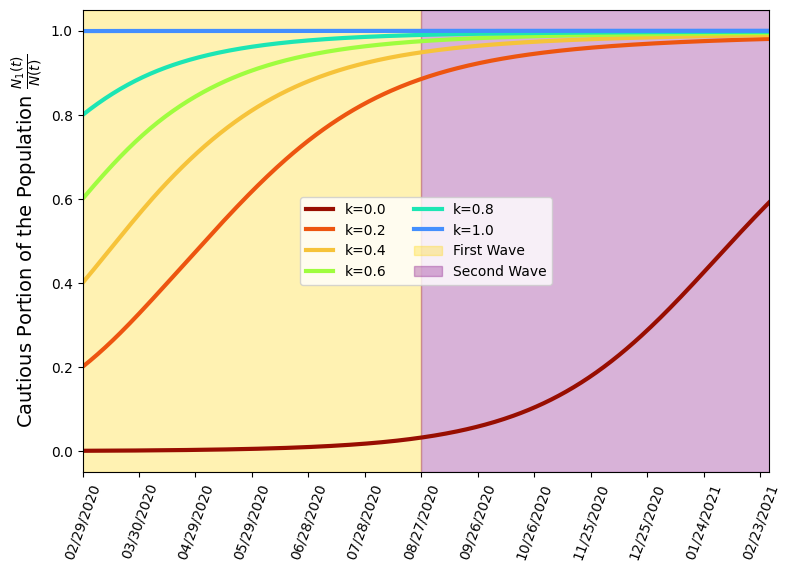

In [33]:
plt.rcParams["figure.figsize"] = (13,4)
plt.rcParams["figure.figsize"] = (13*1.5,4*1.5)
y0 = np.zeros(13)
cmap = plt.cm.turbo  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
altper = 0.8
for i,r in enumerate(np.arange(0,1.2,0.2)):
    p1 = r*(N0 - sum(initial_infection_size))
    p2 = (1-r)*(N0 - sum(initial_infection_size))
    y0[0],y0[1] = p1,p2
    print(y0[0],y0[1])
    y0[2:12] = initial_infection_size[:-1]
    y0[-1] = initial_infection_size[-1]
    extrayears = (365-150)/365
    # extrayears = 0
    t_long = np.linspace(0, len(days)+int(extrayears*365) , len(days)+int(extrayears*365) + 1, dtype=int)
    # sol_long = odeint(full_model_altb, y0, t_long, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit,altper))
    sol_long = odeint(full_model, y0, t_long, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
    print()
    S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long = sol_long[:,0],sol_long[:,1],sol_long[:,2],sol_long[:,3],sol_long[:,4],sol_long[:,5],sol_long[:,6],sol_long[:,7],sol_long[:,8],sol_long[:,9],sol_long[:,10],sol_long[:,11],sol_long[:,12]
    long_sols = [S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long]
    S_long = S1_long+S2_long
    E_long = E1_long+E2_long
    A_long = A1_long+A2_long
    I_long = I1_long+I2_long
    H_long = H1_long+H2_long
    N1_long = np.sum(long_sols[:-1:2],axis=0)
    N2_long = np.sum(long_sols[1::2],axis=0)
    # plt.subplot(121)
    # plt.plot(t_long,H_long,label=f"k={str(np.round(r,2))}",c=cmaplist[-40*i-10],linewidth=2)
    # plt.subplot(122)
    # plt.plot(t_long,D_long,label=f"k={str(np.round(r,2))}",c=cmaplist[-40*i-10],linewidth=2)
    # print(f"k={np.round(r,2)}, first year hospitalizations={int(sum(H_long))}")
    # print(f"k={np.round(r,2)}, deaths after 1 year={int(D_long[-1])}")
    # print(int(D_long[-1])/sum(H_long))
    print(" ")
    plt.subplot(121)
    plt.plot(t_long, N1_long/(N1_long+N2_long), label=f"k={str(np.round(r,2))}",c=cmaplist[-40*i-10],linewidth=3)
plt.subplot(121)
plt.axvspan(-10, 180, color='gold', alpha=0.3,label="First Wave") 
plt.axvspan(180, 400, color='purple', alpha=0.3,label="Second Wave") 
plt.xlim(t_long[0],t_long[-1])
plt.ylabel(r"Cautious Portion of the Population $\frac{N_1(t)}{N(t)}$",fontsize=14)
plt.legend(ncol=2)
# # plt.title('(a)',weight='bold',fontsize=14)
# plt.xticks(np.arange(0,len(t_long),30), dates_long[:len(t_long):30],rotation=70)
# plt.ylabel("Daily Hospitalizations")
# plt.subplot(122)
# plt.axvspan(-10, 180, color='gold', alpha=0.3,label="First Wave") 
# plt.axvspan(180, 400, color='purple', alpha=0.3,label="Second Wave") 
# plt.xlim(t_long[0],t_long[-1])
# # plt.title('(b)',weight='bold',fontsize=14)
# plt.legend(ncol=2,loc='upper left')
plt.xticks(np.arange(0,len(t_long),30), dates_long[:len(t_long):30],rotation=70)
# plt.ylabel("Cummulative Deaths")
plt.show()


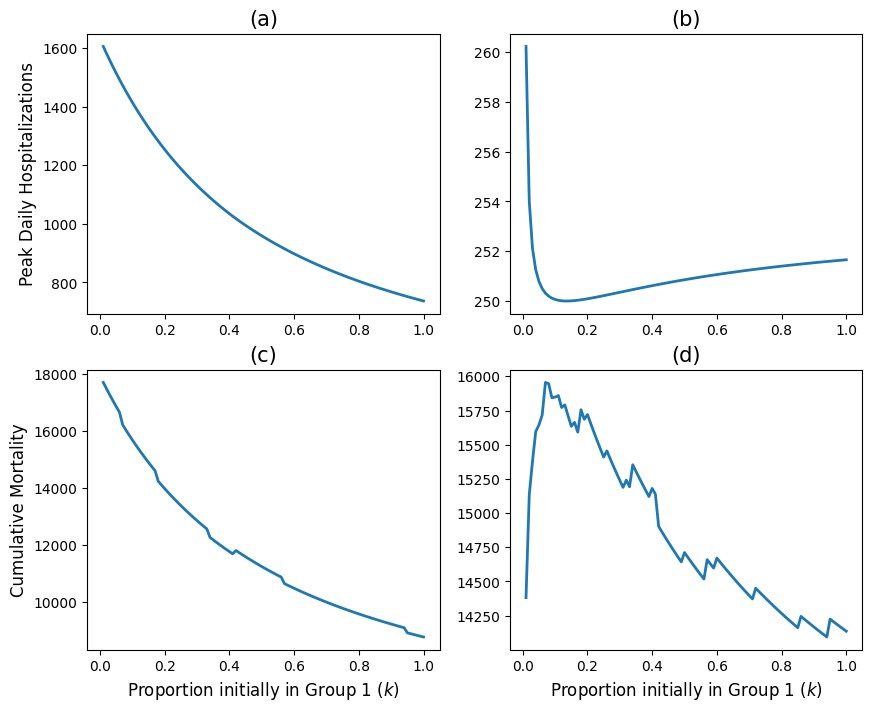

Text(0.5, 0, 'Proportion initially in Group 1 ($k$)')

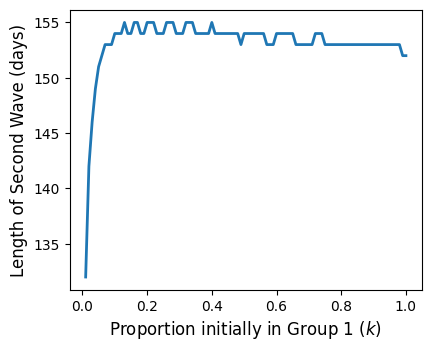

In [31]:
plt.rcParams["figure.figsize"] = (10,8)
PDH1 = []
PDH2 = []
CM1 = []
CM2 = []
W2L = []
cmap = plt.cm.turbo  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
step = 0.01
for i,r in enumerate(np.arange(0.01,1.0+step,step)):
    k = r
    _, _, hosp_peakval_1, hosp_peakval_2, _, wave2_start, wave2_end, wave1_deaths, wave2_deaths, _,_ = model_analysis((a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit,theta_l2_fit,theta_l3_fit,theta_l4_fit))
    PDH1.append(hosp_peakval_1), PDH2.append(hosp_peakval_2)
    CM1.append(wave1_deaths), CM2.append(wave2_deaths)
    W2L.append(wave2_end-wave2_start)
    # print(f"For k={np.round(r,2)}, w1ph = {int(hosp_peakval_1)}, w1d = {int(wave1_deaths)}, w2ph = {int(hosp_peakval_2)}, w2d = {int(wave2_deaths)}, and w2l = {int(wave2_end-wave2_start)}")
# plt.suptitle(f"      First Wave                                                       Second Wave",fontsize=13)
plt.subplot(221)
plt.title(r"(a)", fontsize=15)
plt.plot(np.arange(0.01,1.0+step,step), PDH1, linewidth=2)
plt.ylabel("Peak Daily Hospitalizations",fontsize=12)
plt.subplot(222)
plt.title(f"(b)", fontsize=15)
plt.plot(np.arange(0.01,1.0+step,step), PDH2, linewidth=2)
plt.subplot(223)
plt.title(f"(c)", fontsize=15)
plt.xlabel(r"Proportion initially in Group 1 ($k$)", fontsize=12)
plt.ylabel("Cumulative Mortality",fontsize=12)
plt.plot(np.arange(0.01,1.0+step,step), CM1, linewidth=2)
plt.subplot(224)
plt.title(f"(d)", fontsize=15)
plt.xlabel(r"Proportion initially in Group 1 ($k$)", fontsize=12)
plt.plot(np.arange(0.01,1.0+step,step), CM2, linewidth=2)
plt.show()
plt.subplot(221)
plt.plot(np.arange(0.01,1.0+step,step), W2L, linewidth=2)
plt.ylabel("Length of Second Wave (days)",fontsize=12)
plt.xlabel(r"Proportion initially in Group 1 ($k$)", fontsize=12)

## Visualization of Threshold Value in $a_2$

k=0, cumulative mortality=35300
 
k=0, cumulative mortality=34982
 
k=0, cumulative mortality=34695
 
k=0, cumulative mortality=34435
 
k=0, cumulative mortality=34196
 


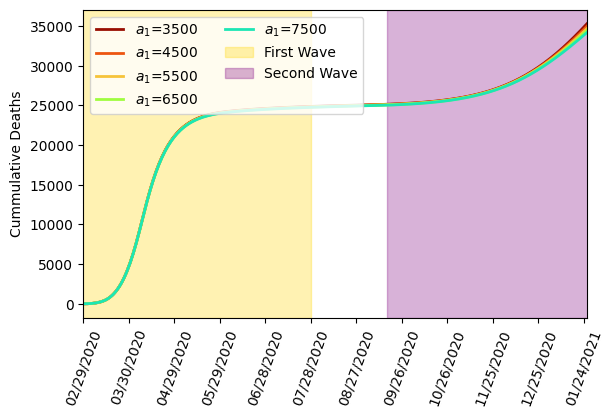

In [15]:
plt.rcParams["figure.figsize"] = (6.5,4)
y0 = np.zeros(13)
r = 0
cmap = plt.cm.turbo  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
a2 = 2300
for i,a1 in enumerate(np.arange(3500,8500,1000)):
    p1 = r*(N0 - sum(initial_infection_size))
    p2 = (1-r)*(N0 - sum(initial_infection_size))
    y0[0],y0[1] = p1, p2
    y0[2:12] = initial_infection_size[:-1]
    y0[-1] = initial_infection_size[-1]
    extrayears = .5
    t_long = np.linspace(0, len(days)+int(extrayears*365) , len(days)+int(extrayears*365) + 1, dtype=int)
    sol_long = odeint(full_model, y0, t_long, args=(a1, a2, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
    S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long = sol_long[:,0],sol_long[:,1],sol_long[:,2],sol_long[:,3],sol_long[:,4],sol_long[:,5],sol_long[:,6],sol_long[:,7],sol_long[:,8],sol_long[:,9],sol_long[:,10],sol_long[:,11],sol_long[:,12]
    long_sols = [S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long]
    S_long = S1_long+S2_long
    E_long = E1_long+E2_long
    A_long = A1_long+A2_long
    I_long = I1_long+I2_long
    H_long = H1_long+H2_long
    plt.plot(t_long,D_long,label=f"$a_1$={str(np.round(a1,2))}",c=cmaplist[-40*i-10],linewidth=2)
    print(f"k={np.round(r,2)}, cumulative mortality={int(D_long[-1])}")
    print(" ")
plt.axvspan(-10, 150, color='gold', alpha=0.3,label="First Wave") 
plt.axvspan(200, 400, color='purple', alpha=0.3,label="Second Wave") 
plt.xlim(t_long[0],t_long[-1])
plt.legend(ncol=2,loc='upper left')
plt.xticks(np.arange(0,len(t_long),30), dates_long[:len(t_long):30],rotation=70)
plt.ylabel("Cummulative Deaths")
plt.show()

## Baseline Behavior Alteration

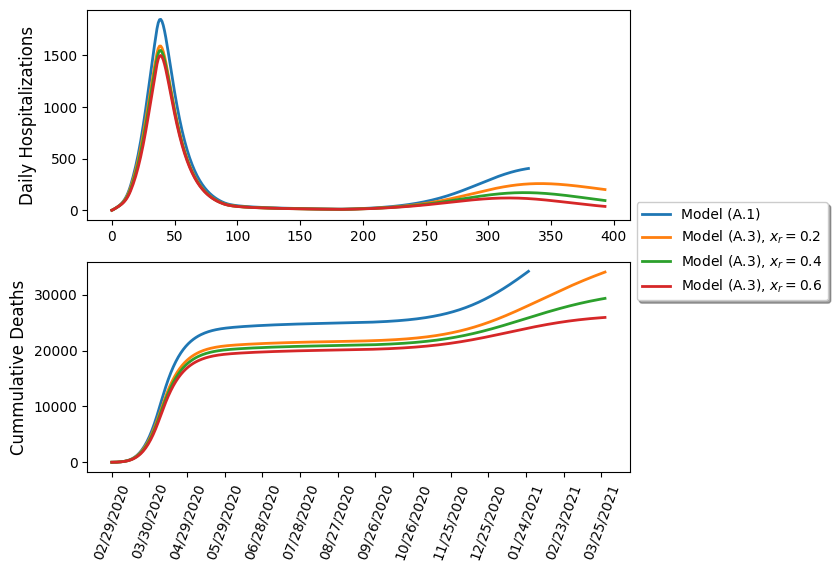

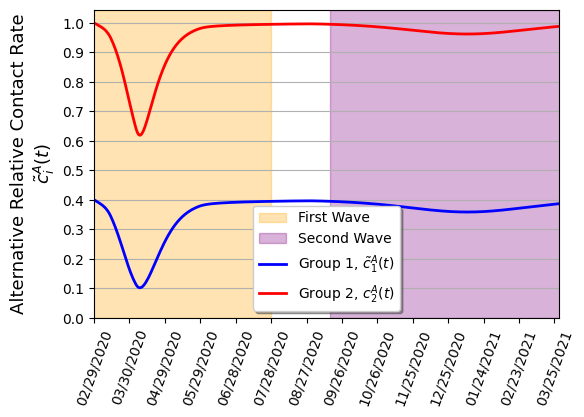

60398.07358746558 24766.74471601212


In [16]:
def full_model_altb(states, t, a_1, a_2, c12, c21, theta_l1, theta_l2, theta_l3, theta_l4, altper):
    S1, S2, E1, E2, A1, A2, I1, I2, H1, H2, R1, R2, D = states
    N = np.sum(states)-D
    N1 = np.sum([S1, E1, A1, I1, H1, R1])
    N2 = np.sum([S2, E2, A2, I2, H2, R2])

    cA1 = np.exp(-(a_1*(H1+H2)/N) + np.log(altper))
    cA2 = np.exp(-a_2*(H1+H2)/N)
    if t >= p4_lockdown_start:
        mult = theta_l4
    elif t >= p3_lockdown_start:
        mult = theta_l3
    elif t >= p2_lockdown_start:
        mult = theta_l2
    elif t>= p1_lockdown_start:
        mult = theta_l1
    else:
        mult = 1
    
    dS1 = -mult*(cA1*S1/N) * (cA1*(Beta_a*A1 + Beta_i*I1) + cA2*(Beta_a*A2 + Beta_i*I2)) + Xi*R1 - (c21*N2*S1/N) + (c12*N1*S2/N)
    dS2 = -mult*(cA2*S2/N) * (cA1*(Beta_a*A1 + Beta_i*I1) + cA2*(Beta_a*A2 + Beta_i*I2)) + Xi*R2 + (c21*N2*S1/N) - (c12*N1*S2/N)

    dE1 = mult*(cA1*S1/N) * (cA1*(Beta_a*A1 + Beta_i*I1) + cA2*(Beta_a*A2 + Beta_i*I2)) - Sigma_e*E1 - (c21*N2*E1/N) + (c12*N1*E2/N)
    dE2 = mult*(cA2*S2/N) * (cA1*(Beta_a*A1 + Beta_i*I1) + cA2*(Beta_a*A2 + Beta_i*I2)) - Sigma_e*E2 + (c21*N2*E1/N) - (c12*N1*E2/N)

    dA1 = (1-r_1)*Sigma_e*E1 - Gamma_a*A1 - (c21*N2*A1/N) + (c12*N1*A2/N)
    dA2 = (1-r_1)*Sigma_e*E2 - Gamma_a*A2 + (c21*N2*A1/N) - (c12*N1*A2/N)

    dI1 = r_1*Sigma_e*E1 - Sigma_i*I1 - (c21*N2*I1/N) + (c12*N1*I2/N)
    dI2 = r_1*Sigma_e*E2 - Sigma_i*I2 + (c21*N2*I1/N) - (c12*N1*I2/N)

    dH1 = r_2*Sigma_i*I1 - Gamma_h*H1 - Delta_h*H1 - (c21*N2*H1/N) + (c12*N1*H2/N)
    dH2 = r_2*Sigma_i*I2 - Gamma_h*H2 - Delta_h*H2 + (c21*N2*H1/N) - (c12*N1*H2/N)

    dR1 = (1-r_2)*Sigma_i*I1 + Gamma_a*A1 + Gamma_h*H1 - Xi*R1
    dR2 = (1-r_2)*Sigma_i*I2 + Gamma_a*A2 + Gamma_h*H2 - Xi*R2

    dD = Delta_h*(H1+H2)
    return np.array([dS1, dS2, dE1, dE2, dA1, dA2, dI1, dI2, dH1, dH2, dR1, dR2, dD])
altper = 0.8
r = 0
plt.rcParams["figure.figsize"] = (7,6)
plt.subplot(211)
plt.plot(t_long[:394],H_long[:394],label='Model (A.1)',linewidth = 2)
plt.subplot(212)
plt.plot(t_long[:394],D_long[:394],label='Model (A.1)',linewidth = 2)
for altper in [0.8,0.6,0.4]:
    y0 = np.zeros(13)
    y0[0],y0[1] = r*(N0 - sum(initial_infection_size)),(1-r)* (N0 - sum(initial_infection_size))
    y0[2:12] = initial_infection_size[:-1]
    y0[-1] = initial_infection_size[-1]
    extrayears = 2
    t_long = np.linspace(0, len(days)+extrayears*365 , len(days)+extrayears*365 + 1, dtype=int)
    sol_long = odeint(full_model_altb, y0, t_long, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit,altper))
    S1_long_altb, S2_long_altb, E1_long_altb, E2_long_altb, A1_long_altb, A2_long_altb, I1_long_altb, I2_long_altb, H1_long_altb, H2_long_altb, R1_long_altb, R2_long_altb, D_long_altb = sol_long[:,0],sol_long[:,1],sol_long[:,2],sol_long[:,3],sol_long[:,4],sol_long[:,5],sol_long[:,6],sol_long[:,7],sol_long[:,8],sol_long[:,9],sol_long[:,10],sol_long[:,11],sol_long[:,12]
    long_sols_altb = [S1_long_altb, S2_long_altb, E1_long_altb, E2_long_altb, A1_long_altb, A2_long_altb, I1_long_altb, I2_long_altb, H1_long_altb, H2_long_altb, R1_long_altb, R2_long_altb, D_long_altb]
    N1_long_altb  = np.sum(long_sols_altb[:-1:2],axis=0)
    N2_long_altb  = np.sum(long_sols_altb[1::2],axis=0)
    N_long_altb  = N1_long_altb + N2_long_altb 
    H_long_altb = H1_long_altb + H2_long_altb
    plt.subplot(211)
    plt.plot(t_long[:394],H_long_altb[:394],label=f'Model (A.3), $x_r={np.round(1-altper,2)}$',linewidth = 2)
    plt.subplot(212)
    plt.plot(t_long[:394],D_long_altb[:394],label=f'Model (A.3), $x_r={np.round(1-altper,2)}$',linewidth = 2)
plt.subplot(211)
plt.ylabel('Daily Hospitalizations',fontsize=12)
plt.legend(fancybox=True, shadow=True, loc='center left', bbox_to_anchor=(1, -0.15))
plt.subplot(212)
plt.ylabel('Cummulative Deaths',fontsize=12)
plt.xticks(t_long[:394:30], dates_long[:394:30],rotation=70)
plt.show()

# plt.rcParams["figure.figsize"] = (6,4)
# plt.axvspan(-10, 150, color='orange', alpha=0.3,label="First Wave") 
# plt.axvspan(200, 400, color='purple', alpha=0.3,label="Second Wave") 
# plt.plot(t_long[:394],(N1_long/N_long)[:394],label=r"Group 1",color='blue',linewidth=2)
# plt.plot(t_long[:394],(N2_long/N_long)[:394],label=r"Group 2",color='red',linewidth=2)
# plt.ylabel(r"$\frac{N_i(t)}{N(t)}$      ", fontsize=16, rotation=0)
# plt.legend(fancybox=True, shadow=True, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xticks(t_long[:394:30], dates_long[:394:30],rotation=70)
# num_grid_lines = 11
# y_ticks = np.linspace(0, 1, num_grid_lines)
# plt.yticks(y_ticks)
# plt.grid(axis='y')
# plt.xlim(0,394)
# plt.show()

## plot contact rates ##
plt.rcParams["figure.figsize"] = (6,4)
cA1_t_altb = np.exp(-a_1_fit*H_long_altb/N_long_altb[:len(H_long_altb)] + np.log(altper))
cA2_t_altb = np.exp(-a_2_fit*H_long_altb/N_long_altb[:len(H_long_altb)])
plt.axvspan(-10, 150, color='orange', alpha=0.3,label="First Wave") 
plt.axvspan(200, 400, color='purple', alpha=0.3,label="Second Wave") 
H_pop_altb = H_long_altb/N_long_altb[:len(H_long_altb)]
plt.ylabel(f"Alternative Relative Contact Rate\n"+ r"$\tilde{c}^A_i(t)$",fontsize=13)
plt.plot(t_long[:394],cA1_t_altb[:394],label=r"Group 1, $\tilde{c}^A_1(t)$",linewidth=2,c='blue')
plt.plot(t_long[:394],cA2_t_altb[:394],label=r"Group 2, $c^A_2(t)$",linewidth=2,c='red')
plt.xticks(t_long[:394:30], dates_long[:394:30],rotation=70)
plt.legend(fancybox=True, shadow=True)
# plt.ylim(0,1.1)
num_grid_lines = 11
y_ticks = np.linspace(0, 1, num_grid_lines)
plt.yticks(y_ticks)
plt.grid(axis='y')
plt.xlim(0,394)
plt.show()

print(sum(H_long[:150]),D_long[150])

/var/folders/x2/08zysc914xxdc9brxb_t1mbc0000gn/T/ipykernel_49869/329676523.py:7: RuntimeWarning: invalid value encountered in log
  cA1 = np.exp(-(a_1*(H1+H2)/N) + np.log(altper))


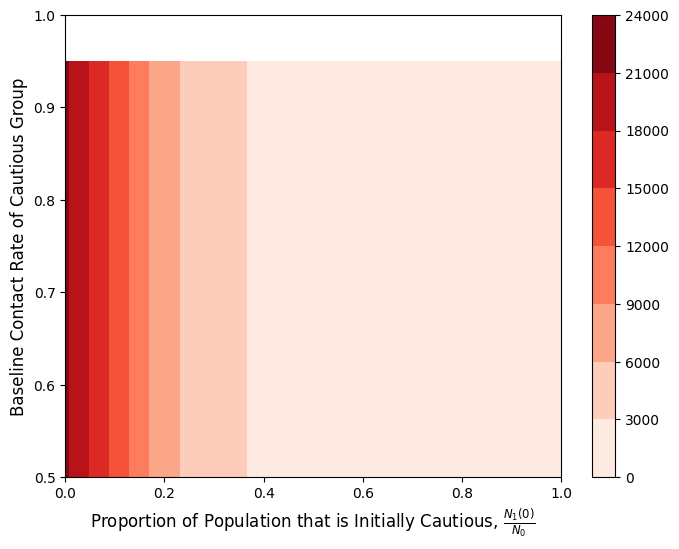

In [17]:
altb = [-np.log(y)/a_1_fit for y in np.arange(0.5,1.1,0.05)]
deaths = np.ones((len(np.arange(0,1.2,0.2)), len(altb)))
plt.rcParams["figure.figsize"] = (8,6)
y0 = np.zeros(13)
for j,alt in enumerate(altb):
    for i,r in enumerate(np.arange(0,1.2,0.2)):
        p1 = r*(N0 - sum(initial_infection_size))
        p2 = (1-r)*(N0 - sum(initial_infection_size))
        y0[0],y0[1] = p1,p2
        y0[2:12] = initial_infection_size[:-1]
        y0[-1] = initial_infection_size[-1]
        extrayears = (365-150)/365
        t_long = np.linspace(0, len(days)+int(extrayears*365) , len(days)+int(extrayears*365) + 1, dtype=int)
        sol_long = odeint(full_model_altb, y0, t_long, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit, alt))
        S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long = sol_long[:,0],sol_long[:,1],sol_long[:,2],sol_long[:,3],sol_long[:,4],sol_long[:,5],sol_long[:,6],sol_long[:,7],sol_long[:,8],sol_long[:,9],sol_long[:,10],sol_long[:,11],sol_long[:,12]
        long_sols = [S1_long, S2_long, E1_long, E2_long, A1_long, A2_long, I1_long, I2_long, H1_long, H2_long, R1_long, R2_long, D_long]
        S_long = S1_long+S2_long
        E_long = E1_long+E2_long
        A_long = A1_long+A2_long
        I_long = I1_long+I2_long
        H_long = H1_long+H2_long
        deaths[i,j] = D_long[-1]

plt.contourf(np.arange(0,1.2,0.2),np.arange(0.5,1.1,0.05),deaths.T,cmap='Reds')
plt.xlabel(r'Proportion of Population that is Initially Cautious, $\frac{N_1(0)}{N_0}$', fontsize=12)
plt.ylim(0.5,1)
plt.ylabel(f'Baseline Contact Rate of Cautious Group', fontsize=12)
plt.colorbar()
plt.show()

efficacy=0.0,deaths=29786.0
efficacy=0.05,deaths=28295.0
efficacy=0.1,deaths=26767.0
efficacy=0.15,deaths=25207.0
efficacy=0.2,deaths=23619.0
efficacy=0.25,deaths=22012.0
efficacy=0.3,deaths=20395.0
efficacy=0.35,deaths=18778.0
efficacy=0.4,deaths=17174.0
efficacy=0.45,deaths=15596.0
efficacy=0.5,deaths=14060.0
efficacy=0.55,deaths=12580.0
efficacy=0.6,deaths=11170.0
efficacy=0.65,deaths=9845.0
efficacy=0.7,deaths=8617.0
efficacy=0.75,deaths=7495.0
efficacy=0.8,deaths=6485.0
efficacy=0.85,deaths=5590.0
efficacy=0.9,deaths=4811.0
efficacy=0.95,deaths=4143.0


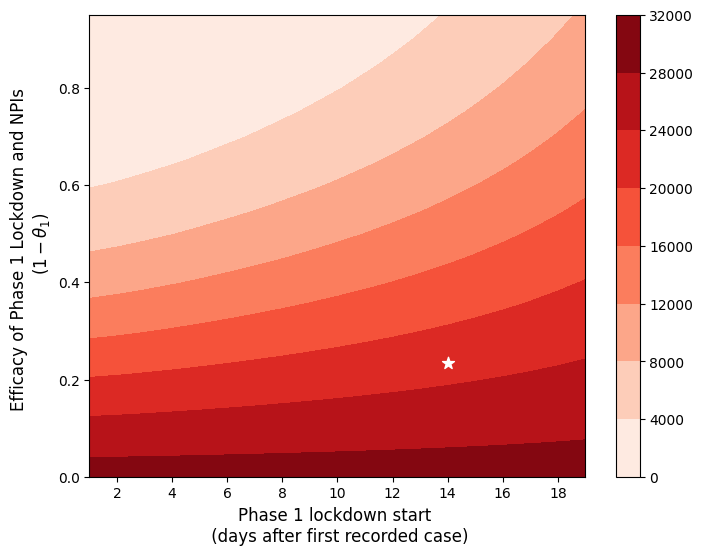

In [12]:
P1_lockdown_start = np.arange(1,20) 
# P2_lockdown_start = np.arange(19,37) 
Theta_l1 = np.arange(0,1,0.05)
# deaths = np.ones((len(P1_lockdown_start), len(P2_lockdown_start)))
deaths = np.ones((len(P1_lockdown_start), len(Theta_l1)))
plt.rcParams["figure.figsize"] = (8,6)
y0 = np.zeros(13)
# for j,p2_start in enumerate(P2_lockdown_start):
for j,theta_l1 in enumerate(Theta_l1):
    for i,p1_start in enumerate(P1_lockdown_start):
        p1_lockdown_start = p1_start 
        # p2_lockdown_start = p2_start 
        p2_lockdown_start = 35 
        # p2_lockdown_start = p1_start + 14
        y0 = np.zeros(13)
        t = np.arange(0,120)
        y0[0],y0[1] = 0, N0 - sum(initial_infection_size)
        y0[2:12] = initial_infection_size[:-1]
        y0[-1] = initial_infection_size[-1]
        # sol = odeint(full_model, y0, t, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, theta_l1_fit, theta_l2_fit, theta_l3_fit, theta_l4_fit))
        sol = odeint(full_model, y0, t, args=(a_1_fit, a_2_fit, c12_fit, c21_fit, 1-theta_l1, theta_l2_fit, theta_l3_fit, theta_l4_fit))
        S1_sol, S2_sol, E1_sol, E2_sol, A1_sol, A2_sol, I1_sol, I2_sol, H1_sol, H2_sol, R1_sol, R2_sol, D_sol = sol[:,0],sol[:,1],sol[:,2],sol[:,3],sol[:,4],sol[:,5],sol[:,6],sol[:,7],sol[:,8],sol[:,9],sol[:,10],sol[:,11],sol[:,12]
        sols = [S1_sol, S2_sol, E1_sol, E2_sol, A1_sol, A2_sol, I1_sol, I2_sol, H1_sol, H2_sol, R1_sol, R2_sol, D_sol]
        deaths[i,j] = D_sol[-1]
        if p1_start==14:
            print(f"efficacy={np.round(theta_l1,2)},deaths={np.round(D_sol[-1],0)}")
# plt.contourf(P1_lockdown_start,P2_lockdown_start,deaths.T,cmap='Reds')
plt.contourf(P1_lockdown_start,Theta_l1,deaths.T,cmap='Reds')
plt.xlabel(f'Phase 1 lockdown start \n (days after first recorded case)', fontsize=12)
# plt.ylabel(f'Phase 2 lockdown start \n (days after first recorded case)', fontsize=12)
plt.ylabel(f'Efficacy of Phase 1 Lockdown and NPIs \n $(1-θ_1)$', fontsize=12)
plt.colorbar()
# plt.scatter(14,35,c='white',marker='*',s=80)
plt.scatter(14,1-0.7664,c='white',marker='*',s=80)
plt.show()